<a href="https://colab.research.google.com/github/agustinivandinocco-python/pythonpracticateoria/blob/main/Colab/clase_07_teoria_backtesting_etapa_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Etapa 3 - Metricas y Ratios de Reisgo del Backtest

In [ ]:
!pip install quantstats -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 1.6 MB/s eta 0:00:00


In [ ]:
import pickle
import pandas as pd
import numpy as np
import yfinance as yf
import quantstats as qs
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
qs.extend_pandas()

In [ ]:
st_momentum = pd.read_csv('st_momentum.csv').set_index('Date').composicion_final
st_growth = pd.read_csv('st_diversified_growth.csv').set_index('Date').sum(axis=1)

In [ ]:
estrategias = pd.concat([st_momentum,st_growth], axis=1, keys=['Momentum','DivGrowth']).dropna()
estrategias

,Momentum,DivGrowth
Date,,
2000-08-01,2.466735,10.184776
2000-08-02,2.472958,10.194017
2000-08-03,2.485816,10.189069
2000-08-04,2.495851,10.217480
2000-08-07,2.510833,10.281459
...,...,...
2023-01-25,10.271397,951.118471
2023-01-26,10.328097,954.415023
2023-01-27,10.346024,944.338407


In [ ]:
def optMPT(df, q = 1_000, FREE_RISK = 0.0):
    retornos = np.log((df/df.shift(1)).dropna())
    datosTickers = []
    for ticker in retornos.columns:
        d = {}
        d['ticker'] = ticker
        d['retorno'] = retornos[ticker].mean() * 252
        d['volatilidad'] = retornos[ticker].std() * (252**0.5)
        d['sharpe'] = (d['retorno']-FREE_RISK) / d['volatilidad']
        datosTickers.append(d)

    datosTickers = pd.DataFrame(datosTickers).set_index('ticker')
    carteras = []
    for i in range(q):
        print (f'Simulando portafolio N° {i+1} de {q}     ', end='\r')
        pond = np.array(np.random.random(len(df.columns)))
        pond = pond/np.sum(pond)
        r={}
        r['retorno'] = np.sum( (retornos.mean() * pond * 252))
        r['volatilidad'] = np.sqrt(np.dot(pond, np.dot(retornos.cov()*252, pond)))
        r['sharpe'] = (r['retorno']-FREE_RISK) / r['volatilidad']
        r['pesos'] = pond.round(4)
        carteras.append(r)

    carteras = pd.DataFrame(carteras)
    optimo = carteras.loc[carteras['sharpe'].idxmax()]
    mejor_port = carteras.iloc[carteras['sharpe'].idxmax()]['pesos']
    datosTickers['ponderacion_optima'] = mejor_port

    plt.rcParams['axes.grid'] = False
    fig, ax = plt.subplots(figsize=(10,7))
    chart = ax.scatter(carteras.volatilidad, carteras.retorno, c=carteras['sharpe'], s=1, cmap='rainbow')

    ax.set_xlabel('Volatilidad')
    ax.set_ylabel('Retorno')

    optimo_txt = f'Optimo'
    optimo_txt += f'\n{retornos.columns[0]}: {optimo.pesos[0]:.0%}'
    optimo_txt += f'\n{retornos.columns[1]}: {optimo.pesos[1]:.0%}'

    ax.scatter(optimo.volatilidad, optimo.retorno, c='white', alpha=0.8, edgecolors='black', s=100)
    ax.text(optimo.volatilidad*1.02, optimo.retorno * 0.94, optimo_txt, fontsize=10, c='k', ha='left', va='center')

    for ticker in retornos.columns:
        vol = datosTickers.loc[ticker,'volatilidad']
        ret = datosTickers.loc[ticker,'retorno']
        ax.scatter(vol, ret,  c='tab:blue', s=1500)
        ax.text(vol, ret, ticker, fontsize=8, c='w', ha='center', va='center')

    ax.set_xlim(datosTickers.volatilidad.min()*0.9, datosTickers.volatilidad.max()*1.05)
    ax.set_ylim(datosTickers.retorno.min()*0.9, datosTickers.retorno.max()*1.05)

    m = (optimo.retorno - FREE_RISK) /  optimo.volatilidad
    tg = [m * x + FREE_RISK for x in [i/100 for i in range(30)]]
    ax.plot([i/100 for i in range(30)], tg, 'k--', alpha=0.5, label='Recta Tagencia optimo')
    ax.legend()
    ax.grid(alpha=0.3)
    fig.colorbar(chart, label='Sharpe Ratio', aspect=40)
    return optimo

,971
retorno,0.15247
volatilidad,0.186299
sharpe,0.81842
pesos,"[0.362, 0.638]"


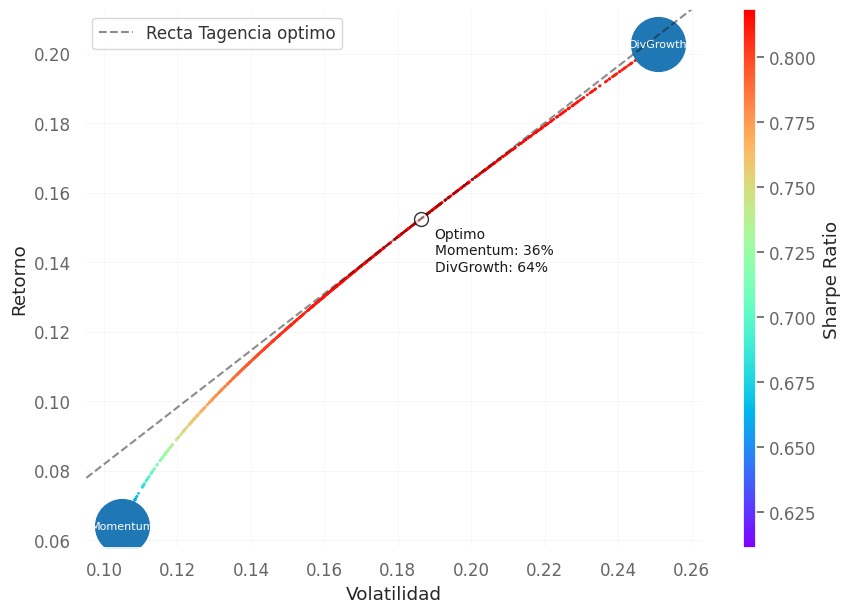

In [ ]:
optMPT(estrategias)

In [ ]:
spy = yf.download('SPY', auto_adjust=True, progress=False)

<Axes: xlabel='Date'>

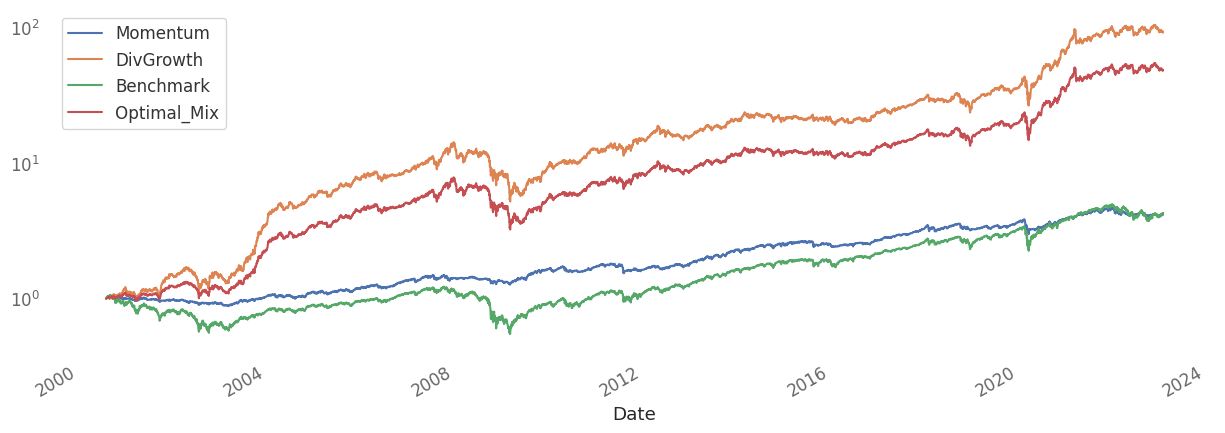

In [ ]:
df= estrategias
df['Benchmark'] = spy['Close']
df = df / df.iloc[0]
df.index = pd.to_datetime(df.index)

pesos = [0.5, 0.5]
df['Optimal_Mix'] = df['Momentum'] * pesos[0] + df['DivGrowth'] * pesos[1]

df.plot(figsize=(15,5), logy=True)

[Performance Metrics]

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2000-08-02   2000-08-02
End Period                 2023-01-31   2023-01-31
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          329.02%      6,053.73%
CAGR﹪                     4.57%        13.47%

Sharpe                     0.43         0.91
Prob. Sharpe Ratio         97.85%       100.0%
Smart Sharpe               0.42         0.89
Sortino                    0.6          1.3
Smart Sortino              0.59         1.27
Sortino/√2                 0.43         0.92
Smart Sortino/√2           0.42         0.9
Omega                      1.18         1.18

Max Drawdown               -55.19%      -60.81%
Longest DD Days            2241         1394
Volatility (ann.)          19.72%       23.21%
R^2                        0.52         0.52
Information Ratio          0.05        

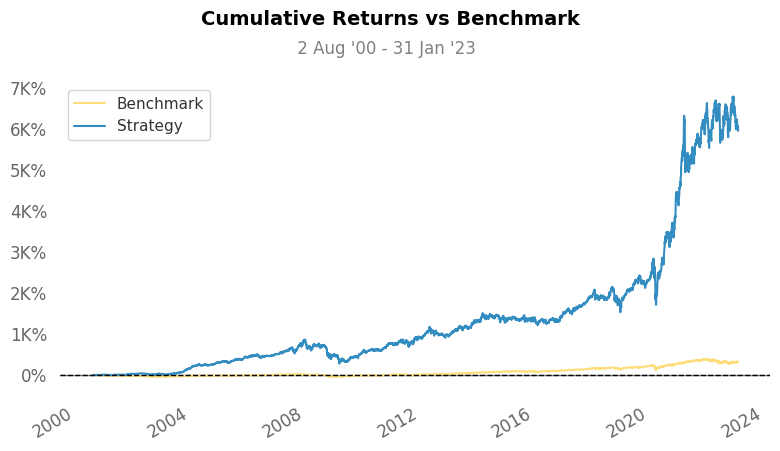

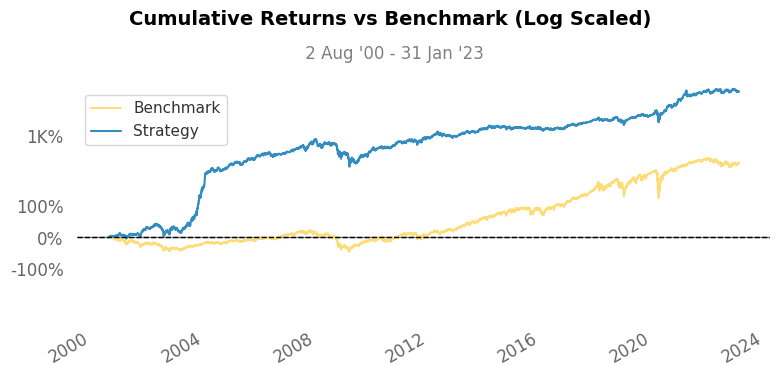

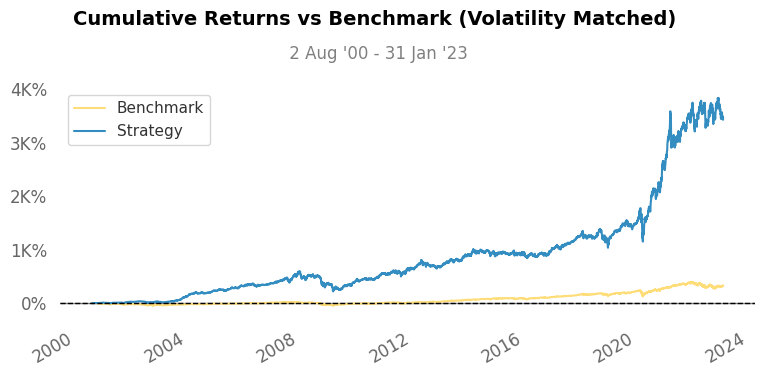

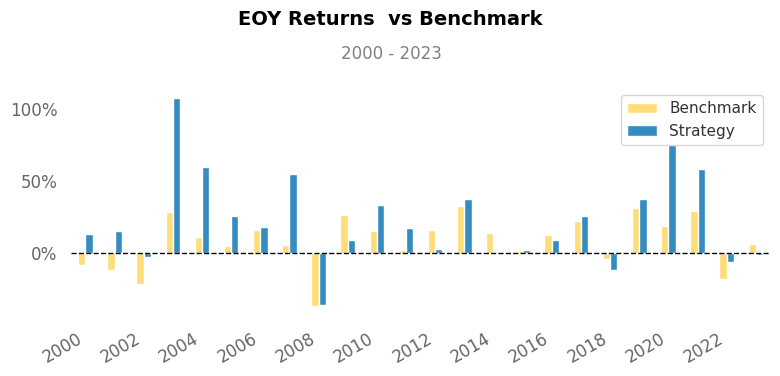

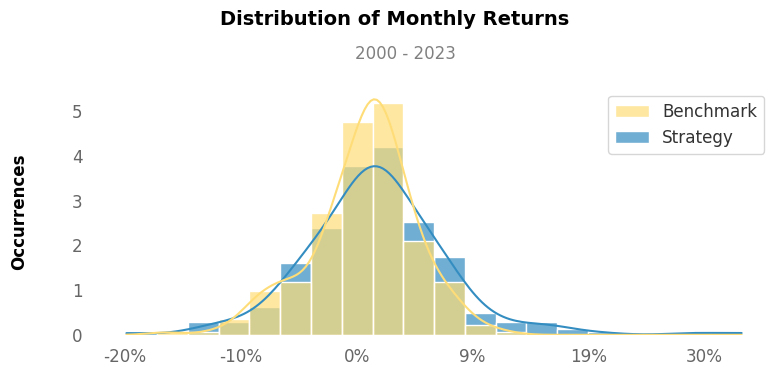

UnsupportedFunctionCall: numpy operations are not valid with resample. Use .resample(...).sum() instead

In [ ]:
strategy = df['Optimal_Mix']
benchmark = df['Benchmark']
qs.extend_pandas()
results = qs.reports.full(strategy, benchmark)

# Los ratios de riesgo a mano

Retornos logaritmicos:

$$ \begin{equation}
St_{log} = \ln\left(\frac{St_{x_i}}{St_{x_{i-1}}}\right)
\end{equation}
 $$

$$ \begin{equation}
B_{log} = \ln\left(\frac{B_{x_i}}{B_{x_{i-1}}}\right)
\end{equation}
 $$

Retornos lineales:

$$ \begin{equation}
St_{lin} = \frac{St_{x_i}}{St_{x_{i-1}}} - 1
\end{equation}
 $$

$$ \begin{equation}
B_{lin} = \frac{B_{x_i}}{B_{x_{i-1}}} - 1
\end{equation}
 $$

In [ ]:
strategy_log = np.log (strategy / strategy.shift())
benchmark_log = np.log (benchmark / benchmark.shift())

strategy_lin = strategy.pct_change()
benchmark_lin = benchmark.pct_change()

# Análisis de métricas

## Retorno Acumulado

$$ \Large r = e^{\sum\limits_{i=1}^{n} {St_{log}}} - 1 $$

$$ \Large r = \prod_{i=1}^{n} \left({St_{lin}+1}\right) -1 $$

In [ ]:
import math

In [ ]:
# Partiendo de retornos logaritmicos

# ESTRATEGIA
r_st = math.e**strategy_log.sum() - 1
# BENCHMARK
r_b = math.e**benchmark_log.sum() - 1


# Partiendo de retornos lineales

# ESTRATEGIA
r_st = (strategy_lin+1).prod()-1
# BENCHMARK
r_b = (benchmark_lin+1).prod()-1

In [ ]:
print(f'Retorno acumulado Estrategia: {r_st:.2%}')

Retorno acumulado Estrategia: 3007.72%


In [ ]:
print(f'Retorno acumulado Benchmark: {r_b:.2%}')

Retorno acumulado Benchmark: 329.02%


## CAGR

$$  \Large \text{CAGR} = \left(\frac{v_f}{v_i}\right)^{\frac{1}{t}} -1  $$

$$ \Large r = \frac{v_f}{v_i} - 1  $$

$$  \Large \text{CAGR} = \left(r+1\right)^{\frac{1}{t}} -1  $$

In [ ]:
years = (strategy_lin.index[-1]-strategy_lin.index[0]).days/365
years

22.515068493150686

In [ ]:
# ESTRATEGIA
r_st = (strategy_lin+1).prod()-1

cagr_st = (1+r_st)**(1/years)-1
f"CAGR: {cagr_st:.2%}, Retorno Acumulado en {years:.1f} años: {r_st:.2%}"

'CAGR: 16.49%, Retorno Acumulado en 22.5 años: 3007.72%'

In [ ]:
# Benchmark
r_b = (benchmark_lin+1).prod()-1

cagr_bench = (1+r_b)**(1/years)-1
f"CAGR: {cagr_bench:.2%}, Retorno Acumulado en {years:.1f} años: {r_b:.2%}"

'CAGR: 6.68%, Retorno Acumulado en 22.5 años: 329.02%'

In [ ]:
# ESTRATEGIA
r_st = (strategy_lin+1).prod()-1
cagr_st = (1+r_st)**(1/years)-1

# BENCHMARK
r_b = (benchmark_lin+1).prod()-1
cagr_bench = (1+r_b)**(1/years)-1

## Volatilidad

$$ {\Large v_{st} \: = \: \sqrt{{\frac {252}{N-1}}\sum _{i=1}^{N}(St_{i}-{\overline {St}})^{2}}}$$

$$ {\Large v_{B} \: = \: \sqrt{{\frac {252}{N-1}}\sum _{i=1}^{N}(B_{i}-{\overline {B}})^{2}}} $$

In [ ]:
v_st = strategy_lin.std() * 252**0.5
v_b = benchmark_lin.std() * 252**0.5

In [ ]:
v_st, v_b

(0.20064936471051478, 0.1972360513541494)

## Sharpe

$$ \large sharpe =  \frac{R - F_{_{RISK}}}{\sigma_R} $$

$$ \large \overline{sharpe}_w  =  \frac{ \sum_{i=1}^w CAGR_i - F_{_{risk}}}{\frac{1}{w} \sum_{i=1}^w\sum_{i=1}^n \frac{ (CAGR_{i} - \overline{CAGR})^2}{n}} $$

### Con un rolling

In [ ]:
w, fr = 252, 0
roll_ret = strategy.pct_change(w)
roll_std = (strategy_lin.rolling(w).std() * (w**.5))
roll_sharpe = (roll_ret - fr) / roll_std

print(f'El Sharpe Medio de la estrategia es {roll_sharpe.mean():.4f}')

El Sharpe Medio de la estrategia es 1.1497


In [ ]:
roll_ret = benchmark.pct_change(w)
roll_std = (benchmark_lin.rolling(w).std() * (w**.5))
roll_sharpe_benchmark = (roll_ret - fr) / roll_std

print(f'El Sharpe Medio del Benchmark es {roll_sharpe_benchmark.mean():.4f}')

El Sharpe Medio del Benchmark es 0.8022


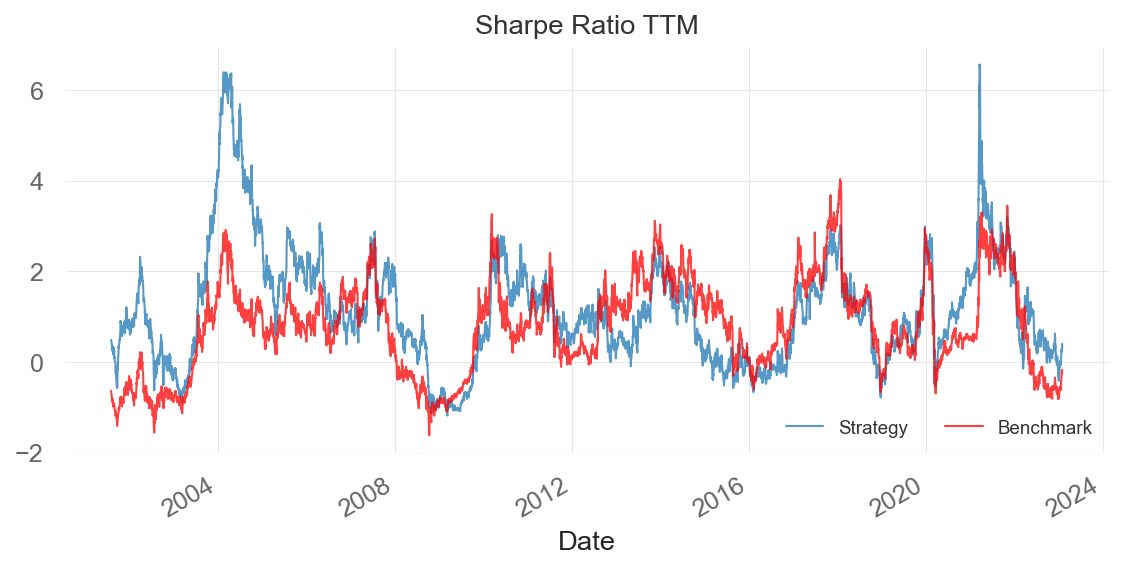

In [ ]:
plt.rcParams['figure.dpi'] = 150
fig, ax = plt.subplots(figsize=(9,4))
roll_sharpe.plot(ax=ax, alpha=0.75,  lw=1, label='Strategy', color='tab:blue')
roll_sharpe_benchmark.plot(ax=ax, alpha=0.75, lw=1, label='Benchmark', color='red')

ax.legend(frameon=False, fontsize=9, ncols=5)
ax.set_title('Sharpe Ratio TTM')
ax.grid(alpha=0.7)

(-2.0, 4.0)

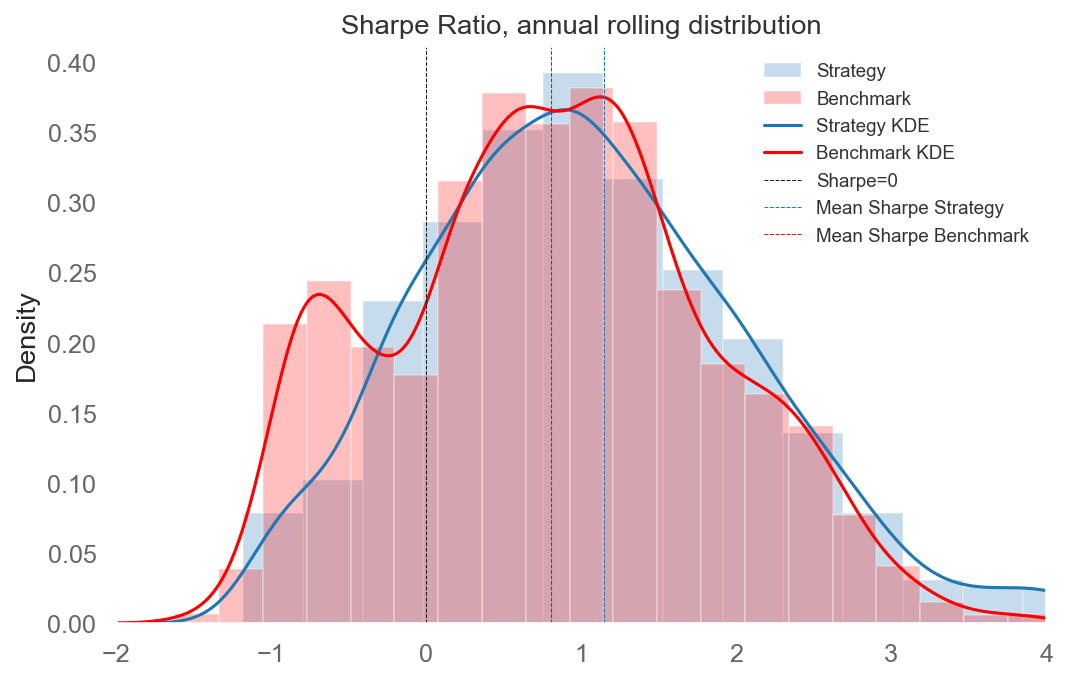

In [ ]:
plt.rcParams['figure.dpi'] = 150
fig, ax = plt.subplots(figsize=(8,5))
roll_sharpe.hist(ax=ax, bins=20, alpha=0.25, density=True, label='Strategy', color='tab:blue')
roll_sharpe_benchmark.hist(ax=ax, bins=20, alpha=0.25, density=True, label='Benchmark', color='red')
roll_sharpe.plot.kde(ax=ax, label='Strategy KDE', color='tab:blue')
roll_sharpe_benchmark.plot.kde(ax=ax, color='red', label='Benchmark KDE')
ax.axvline(0, ls='--', c='k', lw=0.5, label='Sharpe=0')
ax.axvline(roll_sharpe.mean(), ls='--',lw=0.5, label='Mean Sharpe Strategy', color='tab:blue')
ax.axvline(roll_sharpe_benchmark.mean(), ls='--', lw=0.5, label='Mean Sharpe Benchmark', color='red')
ax.legend(frameon=False, fontsize=9)
ax.set_title('Sharpe Ratio, annual rolling distribution')
ax.set_xlim(-2,4)

### Con los agregados anualizados

In [ ]:
fr = 0
sharpe_st = (cagr_st - fr) / v_st
sharpe_benchmark = (cagr_bench - fr) / v_b

msg = f'El Sharpe Medio del Benchmark es {sharpe_benchmark:.2f}'
msg += f'\nEl Sharpe Medio de la estrategia es {sharpe_st:.2f}'
print(msg)

El Sharpe Medio del Benchmark es 0.34
El Sharpe Medio de la estrategia es 0.82


### Anualizando los diarios

In [ ]:
sharpe_st = (strategy_lin.mean() - fr) * 252 / (strategy_lin.std() * (252**0.5))
sharpe_benchmark = (benchmark_lin.mean() - fr) * 252 / (benchmark_lin.std() * (252**0.5))

print(f'El Sharpe Medio del Benchmark es {sharpe_benchmark:.2f}')
print(f'El Sharpe Medio de la estrategia es {sharpe_st:.2f}')

El Sharpe Medio del Benchmark es 0.43
El Sharpe Medio de la estrategia es 0.87


## Sortino

$$ \large {Sortino}_R =  \frac{R - F_{_{RISK}}}{\sigma_{D_R}} $$

donde $\sigma_D $ equivale al semidesvio o desvio de los retornos negativos unicamente

In [ ]:
def sortino(returns):
    semi_desv = (((returns[returns < 0] - returns[returns < 0].mean() ) **2).sum() /len(returns[returns < 0])) **.5
    return returns.mean() / semi_desv * (252**0.5)

# Este es el que usa el autor de la libreria
def sortino(returns):
    semi_desv = ((returns[returns < 0] **2).sum() /len(returns)) **.5
    return returns.mean() / semi_desv * (252**0.5)

In [ ]:
sortino(strategy_lin), sortino(benchmark_lin)

(1.2257763252305551, 0.6030702774093544)

## Max DrawDown

$$ \Large  MDD = \Bigg| \: {\min_{t}\left(\frac{P_i}{\max_{s\leq t}P_i}-1\right)} \: \Bigg| $$

$$ \Large  MDD =  \: {\max_{t}\Bigg|\frac{P_i}{\max_{s\leq t}P_i}-1\Bigg|}  $$

In [ ]:
mdd = abs((strategy / strategy.cummax()-1).min())
mdd = (abs(strategy / strategy.cummax()-1)).max()

In [ ]:
mdd

0.5365465916858232

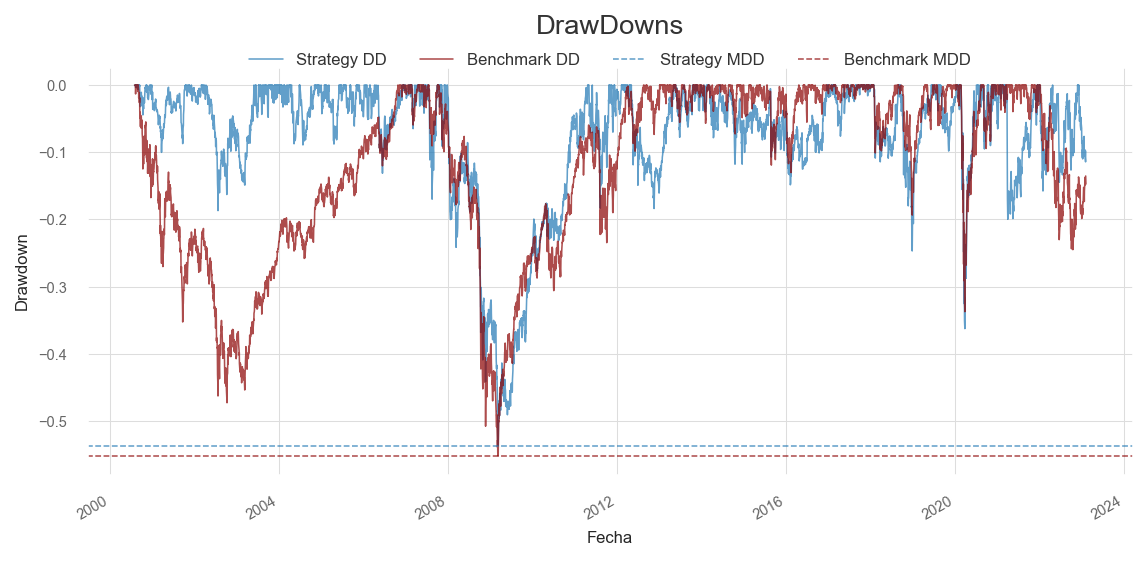

In [ ]:
fig, ax = plt.subplots(figsize=(9,4))

mdd_st = abs((strategy / strategy.cummax()-1).min())
mdd_b = abs((benchmark / benchmark.cummax()-1).min())


st_plot = (strategy / strategy.cummax()-1)
st_plot.plot(ax=ax, lw=0.75, c='tab:blue', alpha=0.7, label='Strategy DD')

b_plot = (benchmark / benchmark.cummax()-1)
b_plot.plot(ax=ax, lw=0.75, c='darkred', alpha=0.7, label='Benchmark DD')

ax.axhline(-mdd_st, ls='--', lw=0.75, c='tab:blue', alpha=0.7, label='Strategy MDD')
ax.axhline(-mdd_b, ls='--', lw=0.75, c='darkred', alpha=0.7, label='Benchmark MDD')
ax.legend(frameon=False, ncols=4, fontsize=8, loc='upper center', bbox_to_anchor=(0.5, 1.07))
ax.set_title('DrawDowns', y=1.05)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
ax.set_xlabel('Fecha', fontsize=8)
ax.set_ylabel('Drawdown', fontsize=8)
ax.grid()

In [ ]:
max_dd_st = (strategy / strategy.cummax()-1).min()
max_dd_bench = (benchmark / benchmark.cummax()-1).min()

max_dd_st, max_dd_bench

(-0.5365465916858232, -0.5518944074389203)

## Average DrawDown

$$ \Large  ADD =  \: {\overline {1-\frac{P_i}{\max_{s\leq t}P_i}}}  $$

In [ ]:
add_st = (1-strategy / strategy.cummax()).mean()
add_b = (1- benchmark / benchmark.cummax()).mean()

add_st, add_b

(0.07674357875083236, 0.11918095611297211)

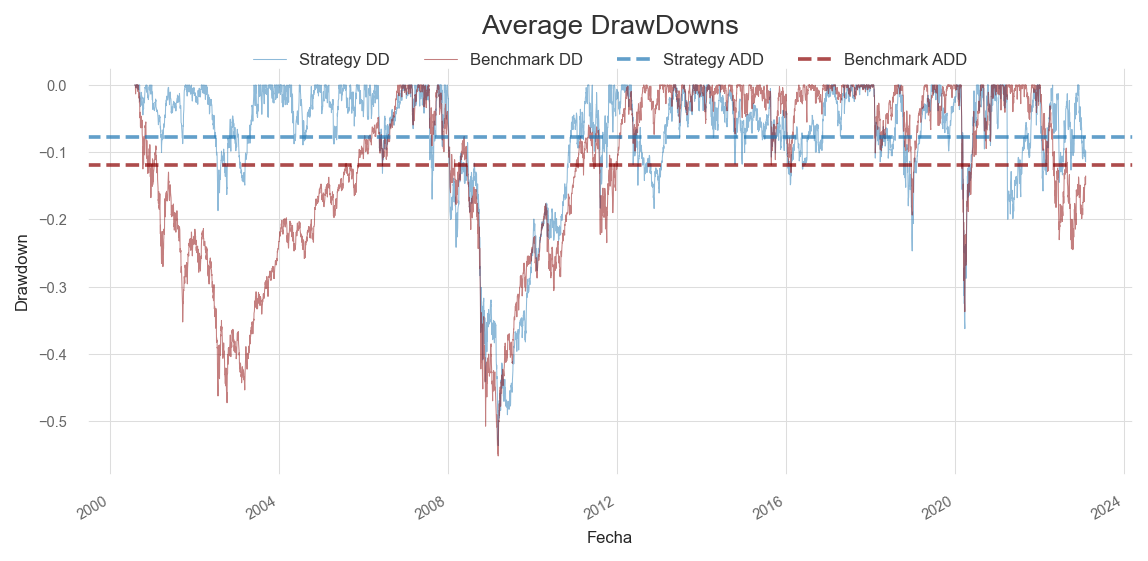

In [ ]:
fig, ax = plt.subplots(figsize=(9,4))

add_st = (strategy / strategy.cummax()-1).mean()
add_b = (benchmark / benchmark.cummax()-1).mean()


st_plot = (strategy / strategy.cummax()-1)
st_plot.plot(ax=ax, lw=0.5, c='tab:blue', alpha=0.5, label='Strategy DD')

b_plot = (benchmark / benchmark.cummax()-1)
b_plot.plot(ax=ax, lw=0.5, c='darkred', alpha=0.5, label='Benchmark DD')

ax.axhline(add_st, ls='--', lw=1.75, c='tab:blue', alpha=0.7, label='Strategy ADD')
ax.axhline(add_b, ls='--', lw=1.75, c='darkred', alpha=0.7, label='Benchmark ADD')
ax.legend(frameon=False, ncols=4, fontsize=8, loc='upper center', bbox_to_anchor=(0.5, 1.07))
ax.set_title('Average DrawDowns', y=1.05)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
ax.set_xlabel('Fecha', fontsize=8)
ax.set_ylabel('Drawdown', fontsize=8)
ax.grid()

## Max DrawDown Dias

In [ ]:
def getDD(prices):
    maximos_mascara = prices.cummax() == prices
    dd = pd.Series(maximos_mascara.loc[maximos_mascara].index).diff()
    return dd.sort_values(ascending=False).head(10)

In [ ]:
getDD(strategy)

254   1211 days
335    924 days
42     415 days
297    366 days
22     291 days
499    268 days
412    264 days
187    229 days
507    216 days
406    213 days
Name: Date, dtype: timedelta64[ns]

In [ ]:
getDD(benchmark)

15    2245 days
60    1773 days
215    273 days
333    204 days
324    192 days
388    173 days
68     110 days
235     92 days
350     91 days
58      78 days
Name: Date, dtype: timedelta64[ns]

In [ ]:
def ddDays(prices, threshold=10):
    maximos_mascara = prices.cummax() == prices
    dd = pd.Series(maximos_mascara.loc[maximos_mascara].index).diff()
    return dd.sort_values(ascending=False).iloc[:threshold].mean().days

In [ ]:
print(f'Top10 DD Estrategia, promedio duracion: {ddDays(strategy)} dias')
print(f'Top10 DD Benchmark, promedio duracion: {ddDays(benchmark)} dias')

Top10 DD Estrategia, promedio duracion: 439 dias
Top10 DD Benchmark, promedio duracion: 523 dias


## r^2

$$  \rho(\text{St, B}) = \frac{cov(St,B)}{\sigma_{St}.\sigma_B}   = \frac{\sum_{i=1}^{n} (St_i - \bar{St})(B_i - \bar{B})}{\sqrt{\sum_{i=1}^{n} (St_i - \bar{St})^2 \sum_{i=1}^{n} (B_i - \bar{B})^2}}
 $$

In [ ]:
r2 = strategy_lin.corr(benchmark_lin)**2
r2

0.5644025526613147

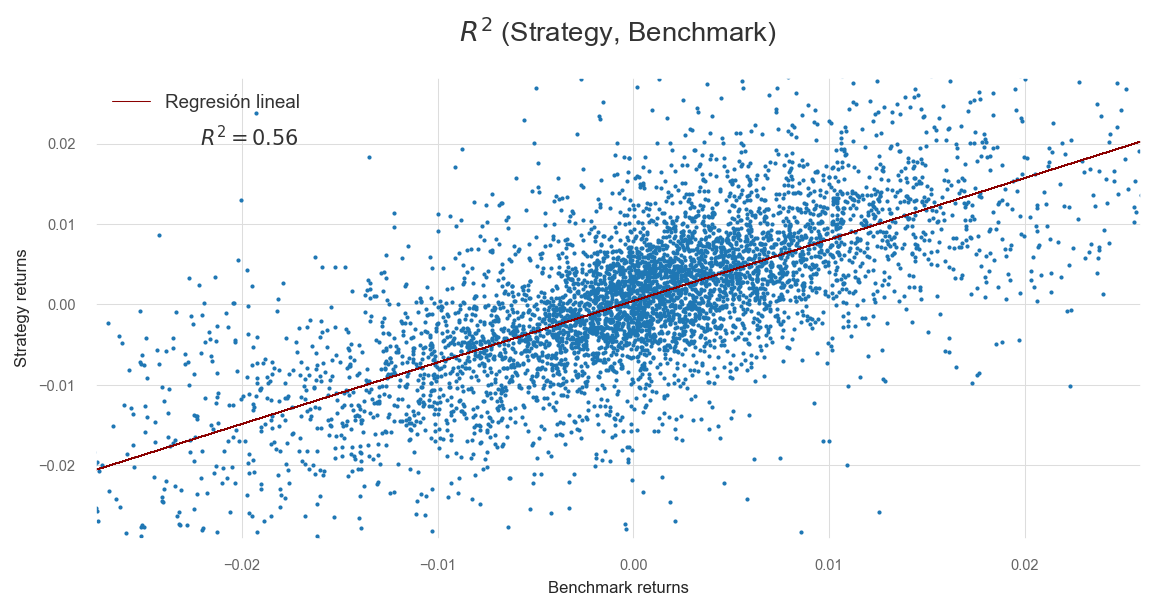

In [ ]:
fig, ax = plt.subplots(figsize=(9,4))

coefficients = np.polyfit(benchmark_lin.dropna(), strategy_lin.dropna(), 1)
p = np.poly1d(coefficients)
ax.plot(benchmark_lin, p(benchmark_lin), lw=0.5, c='darkred', label='Regresión lineal')


ax.scatter(benchmark_lin, strategy_lin, s=1, color='tab:blue')
ax.set_title( f'$R^2$ (Strategy, Benchmark)', y=1.05)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
ax.legend(frameon=False, fontsize=9, loc='upper left')
ax.set_xlabel('Benchmark returns', fontsize=8)
ax.set_ylabel('Strategy returns', fontsize=8)
ax.set_xlim(benchmark_lin.quantile(0.02),benchmark_lin.quantile(0.98))
ax.set_ylim(strategy_lin.quantile(0.02),strategy_lin.quantile(0.98))

text = f'$R^2 = {r2:.2f}$'
ax.text(0.1, 0.85, text, transform=ax.transAxes, fontsize=10)
ax.grid()

## Coeficiente de "linealidad"

$$  \rho(\text{P, L}) = \frac{cov(P,L)}{\sigma_{P}.\sigma_L}   = \frac{\sum_{i=1}^{n} (P_i - \overline{P})(L_i - \overline{L})}{\sqrt{\sum_{i=1}^{n} (P_i - \overline{P})^2 \sum_{i=1}^{n} (L_i - \overline{L})^2}}
 $$

In [ ]:
def coefLin(P):
    x = pd.Series(range(1, len(P)+1))
    m = (P.iloc[-1]-P.iloc[0]) / len(P)
    L = P.iloc[0] + m * x
    return P.reset_index(drop=True).corr(L)

In [ ]:
coefLin(strategy), coefLin(benchmark)

(0.8312130640785175, 0.8801288611268442)

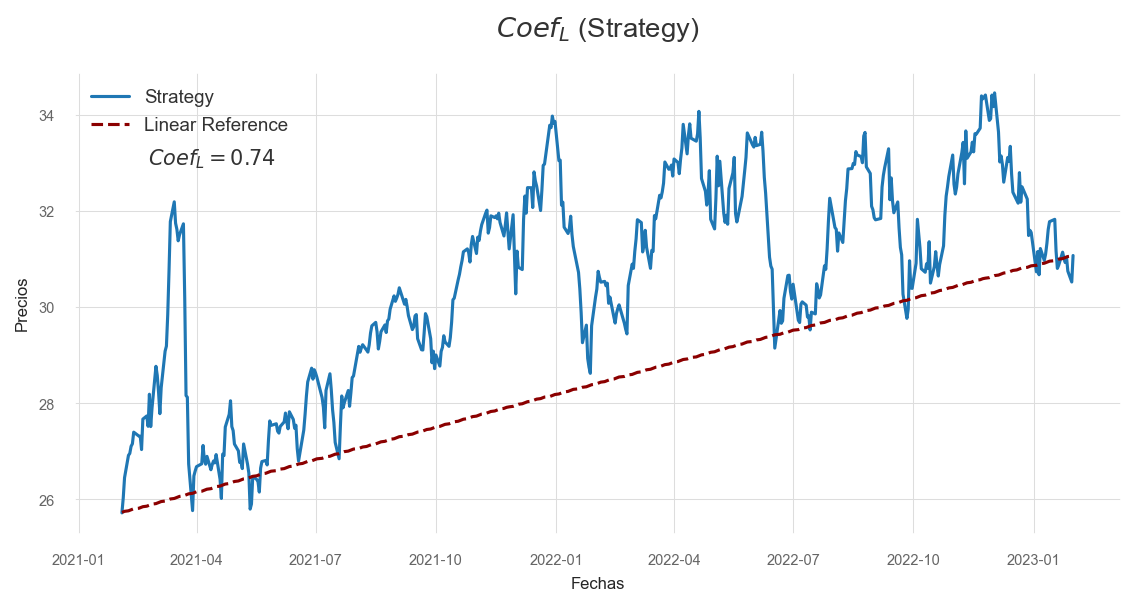

In [ ]:
fig, ax = plt.subplots(figsize=(9,4))
px = strategy.iloc[-500:]
x = pd.Series(range(1, len(px)+1))
m = (px.iloc[-1]-px.iloc[0]) / len(px)
y = px.iloc[0] + m * x

ax.plot(px.index, px.reset_index(drop=True), color='tab:blue', label='Strategy')
ax.plot(px.index, y, color='darkred', ls='--', label='Linear Reference')

ax.set_title( f'$Coef_L$ (Strategy)', y=1.05)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
ax.legend(frameon=False, fontsize=9, loc='upper left')
ax.set_xlabel('Fechas', fontsize=8)
ax.set_ylabel('Precios', fontsize=8)

text = f'$Coef_L = {coefLin(px):.2f}$'
ax.text(0.07, 0.8, text, transform=ax.transAxes, fontsize=10)
ax.grid()

### Con las estrategias por separado

In [ ]:
df= estrategias
df['Benchmark'] = spy['Close']
df = df / df.iloc[0]
df.index = pd.to_datetime(df.index)

pesos = [0.7, 0.3]
df['Optimal_Mix'] = df['Momentum'] * pesos[0] + df['DivGrowth'] * pesos[1]

df = df.reset_index()
df['x'] = df.index+ 1

In [ ]:
# La de la estrategia trend-following
df['Momentum'].corr(df.x)

0.9556439042674113

In [ ]:
# LA estrategia high beta de portfolios
df['DivGrowth'].corr(df.x)

0.8112726665926656

In [ ]:
# El mix 70/30
df['Benchmark'].corr(df.x)

0.8801288611268442

## CALMAR Ratio

$$ \Large \text{CALMAR} \: =  \: \frac{\text{CAGR}}{-\max{DD}} $$

El problema es que queda relativo a la cantidad de años del periodo

- Muchos años hacen "bajar" o estabilizar valores de CAGR en torno al 5%/7%
- Muchos años hacen "subir" o marcar un piso de drawdown del orden del 40% promedio en equity


=> No hay un valor de referencia como en otros indicadores por ej. sharpe >1, o tailRisk >1

In [ ]:
calmar_st = cagr_st / -max_dd_st
calmar_bench = cagr_bench / -max_dd_bench

calmar_st, calmar_bench

(0.307324525523476, 0.12107373132917361)

## Recovery Factor

$$ \Large R_F \: =  \: \frac{\text{r}}{-\max{DD}} = \frac {\frac{v_f}{v_i} - 1}{-\max{DD}} $$

Algo asi como cuantas veces ganaste lo máximo que llegaste a perder

In [ ]:
def recoverFactor(prices):
    returns = prices.pct_change().dropna()
    retorno_acum = (returns+1).prod()-1
    dd_max = -1*(returns / returns.cummax()-1).min()
    return round(retorno_acum / dd_max, 2)

recoverFactor(strategy), recoverFactor(benchmark)

(11.67, 1.24)

## Ulcer Index

$$ \Large \text{U}_\text{IDX} = \sqrt{\frac{1}{n} \sum_{t=1}^{n} \text{EMA}_{period}\left[\left(\frac{P_t - \max_{i=1}^{t} P_i}{\max_{i=1}^{t} P_i}\right)^2\right]} $$


In [ ]:
def ulcer(P, period = 252):
    rsq = ((P - P.cummax()) / P.cummax())**2
    rsq = rsq.ewm(span=period).mean()
    return round(rsq.mean()**0.5, 6)

In [ ]:
ulcer(strategy), ulcer(benchmark)

(0.120839, 0.171711)

## Skewness

$$ \large  skew =  \frac{\mu_3}{\sigma^3}  =  \frac{\sum_{i=1}^{n} \frac{1}{n} . (X_i - \bar{X} )^3}{\sigma^3} $$

$$ \large  skew_{St} = \frac{\sum_{i=i}^{n} \frac{1}{n} . (St_i - \overline{St} )^3}{\sigma_{St}^3} $$

$$ \large  skew_{B} = \frac{\sum_{i=i}^{n} \frac{1}{n} . (B_i - \bar{B} )^3}{\sigma_{B}^3} $$

In [ ]:
strategy_lin.skew(), benchmark_lin.skew()

(-0.3996488897816627, -0.014556323978376173)

## Kurtosis

$$ \Large kurtosis = \frac{\sum_{i=1}^n (X_i-\bar{X})^4}{n . \sigma^4}$$


$$ \Large \text{K}_{St} = \frac{\sum_{i=1}^n (St_i-\overline{St})^4}{n . \sigma_{St}^4}$$

$$ \Large \text{K}_{B} = \frac{\sum_{i=1}^n (B_i-\overline{B})^4}{n . \sigma_{B}^4}$$

Coeficiente de apuntamiento

<div style="width:600px;float:left;">
    <br>La Curtosis nos da una idea de la forma, mientras mas alta, mas valores cerca de la media y mas gruesas las colas
    <ul>
        <li> Leptocúrtica,  Curtosis > 3 (más apuntada y con colas más gruesas que la normal) </li>
        <li> Platicúrtica,  Curtosis < 3 (menos apuntada y con colas menos gruesas que la norma) </li>
        <li> Mesocúrtica,   Curtosis = 3 (tiene una distribución normal) </li>
    </ul>
</div>
<div style="width:350px;float:right;margin-top:-25px;">
    <img src="imagenes/kurtosis.png" style="width:280px;height:230px;float:left;">
</div>


In [ ]:
k_st = strategy_lin.kurtosis()
k_b = benchmark_lin.kurtosis()

k_st, k_b

(6.990894343129696, 11.819324904587539)

## Rendimientos diario mensual y anual

In [ ]:
# Resampleo

mensual_st = strategy.resample('M').last()
mensual_bench = benchmark.resample('M').last()

mensual_st_ret = mensual_st / mensual_st.shift() -1
mensual_bench_ret = mensual_bench / mensual_bench.shift() -1

q_meses = len(mensual_st)

In [ ]:
# Esperanza

mensual_exp_st = (mensual_st.iloc[-1] / mensual_st.dropna().iloc[0]) ** (1/q_meses)-1
mensual_exp_bench = (mensual_bench.iloc[-1] / mensual_bench.dropna().iloc[0]) ** (1/q_meses)-1

mensual_exp_st, mensual_exp_bench

(0.01269594110987482, 0.005195410431155567)

In [ ]:
# Minimos

mensual_st_min = mensual_st_ret.min()*100
mensual_bench_min = mensual_bench_ret.min()*100

mensual_st_min, mensual_bench_min

(-17.022140653482708, -16.518691763077697)

In [ ]:
# Máximos

mensual_st_max = mensual_st_ret.max()*100
mensual_bench_max = mensual_bench_ret.max()*100

mensual_st_max, mensual_bench_max

(26.734097174084948, 12.698367345471361)

In [ ]:
def getResampleMetrics(period='M'):

    resample_st = strategy.resample(period).last()
    resample_bench = benchmark.resample(period).last()

    resample_st_ret = resample_st / resample_st.shift() -1
    resample_bench_ret = resample_bench / resample_bench.shift() -1

    q = len(resample_st)

    resample_exp_st = (resample_st.iloc[-1] / resample_st.dropna().iloc[0]) ** (1/q)-1
    resample_exp_bench = (resample_bench.iloc[-1] / resample_bench.dropna().iloc[0]) ** (1/q)-1

    resample_st_min = resample_st_ret.min()*100
    resample_bench_min = resample_bench_ret.min()*100

    resample_st_max = resample_st_ret.max()*100
    resample_bench_max = resample_bench_ret.max()*100

    r = {'exp_st': resample_exp_st*100, 'exp_bench': resample_exp_bench*100,
         'worst_st': resample_st_min, 'worst_bench': resample_bench_min,
         'best_st': resample_st_max, 'best_bench': resample_bench_max }

    rs = pd.Series(r).round(2)
    return rs

getResampleMetrics(period='M')

exp_st          1.27
exp_bench       0.52
worst_st      -17.02
worst_bench   -16.52
best_st        26.73
best_bench     12.70
dtype: float64

In [ ]:
getResampleMetrics(period='Y')

exp_st         15.12
exp_bench       6.64
worst_st      -31.90
worst_bench   -36.80
best_st        65.13
best_bench     32.31
dtype: float64

## Kelly

$$ \Large f = {\frac {P_w}{\overline{L}}}-{\frac {1-P_w}{\overline{W}}} $$

* Pw: Probabilidad de ganar
* Pl: Probabilidad de perder
* $\overline{W}$: Promedio de trades ganadores
* $\overline{L}$: Promedio de trades perdedores

https://en.wikipedia.org/wiki/Kelly_criterion

In [ ]:
perdedores = strategy_log[strategy_log < 0]
ganadores = strategy_log[strategy_log > 0]

p_win = len(ganadores) / len(strategy_log)
p_loss = 1 - p_win

win_m = ganadores.mean()
loss_m = -perdedores.mean()

kelly = p_win/loss_m  - p_loss/win_m
kelly

7.81183598334853

In [ ]:
def getKelly(returns):
    perdedores = returns[returns < 0]
    ganadores = returns[returns > 0]
    # Probabilidades (numeradores)
    p_win = len(ganadores) / len(returns)
    p_loss = 1 - p_win
    # Medias (denominadores)
    win_m = ganadores.mean()
    loss_m = -perdedores.mean()
    kelly = p_win/loss_m  - p_loss/win_m
    return kelly

In [ ]:
print(f'Kelly Estrategia: {getKelly(strategy_log):.2%}, Kelly Benchmark: {getKelly(benchmark_log):.2%}')

Kelly Estrategia: 781.18%, Kelly Benchmark: 332.05%


In [ ]:
getKelly(yf.download('AAPL', progress=False).Close.pct_change())

1.036118310822971

In [ ]:
getKelly(yf.download('GGAL', progress=False).Close.pct_change())

0.4636183819353725

In [ ]:
getKelly(yf.download('SUPV', progress=False).Close.pct_change())

-0.4905072913441444

## Riesgo de ruina

### Riesgo de ruina Asumiendo normalidad

$$ \Large \text{RoR} = \left(\frac{2}{1+\mu r^{-1}}-1 \right)^\frac{C}{r}  $$

$$ \Large r = \sqrt{\mu^2 + \sigma^2}  $$

In [ ]:
mu = strategy_lin.mean()
sigma = strategy_lin.std()
cap_inicial = 1

r = (mu**2 + sigma**2)**0.5
riesgo_ruina = (2/(1+mu/r)-1)**(cap_inicial/r)
f"Riesgo Ruina estrategia {riesgo_ruina:.4%}"

'Riesgo Ruina estrategia 0.0183%'

In [ ]:
mu = benchmark_lin.mean()
sigma = benchmark_lin.std()
cap_inicial = 1

r = (mu**2 + sigma**2)**0.5
riesgo_ruina = (2/(1+mu/r)-1)**(cap_inicial/r)
f"Riesgo Ruina benchmark {riesgo_ruina:.4%}"

'Riesgo Ruina benchmark 1.3034%'

In [ ]:
def RoR(returns, capital=1):
    mu = returns.mean()
    sigma = returns.std()
    r = (mu**2 + sigma**2)**0.5
    return (2/(1+mu/r)-1)**(capital/r)

In [ ]:
RoR(strategy_lin), RoR(benchmark_lin)

(0.00018287317854952557, 0.01303409010531419)

In [ ]:
RoR(yf.download(['SUPV','GGAL','BTC-USD','SPY']).Close.pct_change())

[*********************100%%**********************]  4 of 4 completed


Ticker
BTC-USD    0.049559
GGAL       0.387039
SPY        0.004127
SUPV       0.493043
dtype: float64

In [ ]:
res=[]
returns_btc = yf.download('BTC-USD').Close.pct_change()
returns_ggal = yf.download('GGAL', auto_adjust=True).Close.pct_change()

for i in range(10000):
    capital = (i+1)/10000
    res.append({
     'Strategy':RoR(strategy_lin, capital),
     'Benchmark':RoR(benchmark_lin, capital),
     'BTC':RoR(returns_btc, capital),
     'GGAL':RoR(returns_ggal, capital)
    })
res = pd.DataFrame(res)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


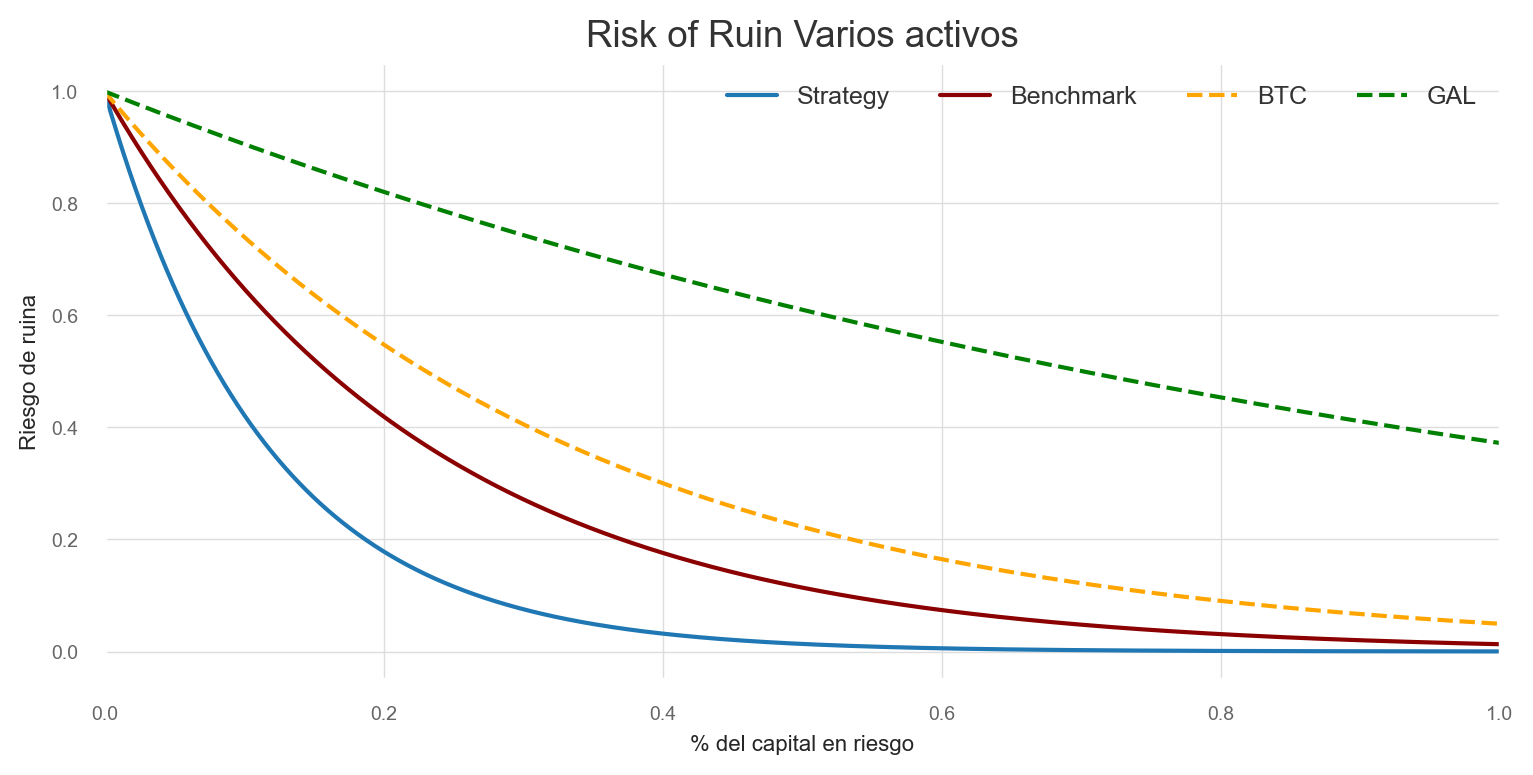

In [ ]:
plt.rcParams['figure.dpi'] = 200
fig, ax = plt.subplots(figsize=(9,4))
ax.plot(res.index/10000, res.Strategy, color='tab:blue', label='Strategy')
ax.plot(res.index/10000, res.Benchmark, color='darkred', label='Benchmark')
ax.plot(res.index/10000, res.BTC, ls='--', color='orange', label='BTC')
ax.plot(res.index/10000, res.GGAL, ls='--', color='green', label='GAL')
ax.set_title( f'Risk of Ruin Varios activos')
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
ax.legend(frameon=False, fontsize=9, loc='upper right', ncols=4)
ax.set_xlabel('% del capital en riesgo', fontsize=8)
ax.set_ylabel('Riesgo de ruina', fontsize=8)
ax.set_xlim(0,1)
ax.grid()

### Riesgo de ruina Empirico

$$
\Large
\begin{align*}
A &= \sqrt{P_W \cdot \overline{W}^2 - P_L \cdot \overline{L}^2} \\[1em]
Z &= P_W \cdot \overline{W} - P_L \cdot \overline{L} \\[0.5em]
P &= 0.5 \cdot (1 + \frac{Z}{A}) \\[0.5em]
\text{RoR} &= \left(\frac{1-P}{P}\right)^{\frac{C}{A}}
\end{align*}
$$

In [ ]:
def RoRemp(returns, capital=1):
    w = returns.loc[returns>0]
    l = returns.loc[returns<0]
    avg_l = abs(l.mean() )
    avg_w = w.mean()
    Pw = len(w)/len(returns)
    Pl = len(l)/len(returns)
    A = (Pw*(avg_w**2) - Pl*(avg_l**2))**0.5
    Z = Pw*avg_w - Pl*avg_l
    P = 0.5 * (1+(Z/A))
    R = ((1-P)/P)**(capital/A)
    return R

In [ ]:
returns_spy = yf.download('SPY', auto_adjust=True).Close.pct_change()
returns_btc = yf.download('BTC-USD').Close.pct_change()
returns_ggal = yf.download('GGAL', auto_adjust=True).Close.pct_change()
returns_supv = yf.download('SUPV', auto_adjust=True).Close.pct_change()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [ ]:
res=[]
for i in range(10000):
    capital = (i+1)/10000
    res.append({
     'SPY':RoRemp(returns_spy, capital),
     'BTC':RoRemp(returns_btc, capital),
     'GGAL':RoRemp(returns_ggal, capital),
     'SUPV':RoRemp(returns_supv, capital),
    })
res = pd.DataFrame(res)

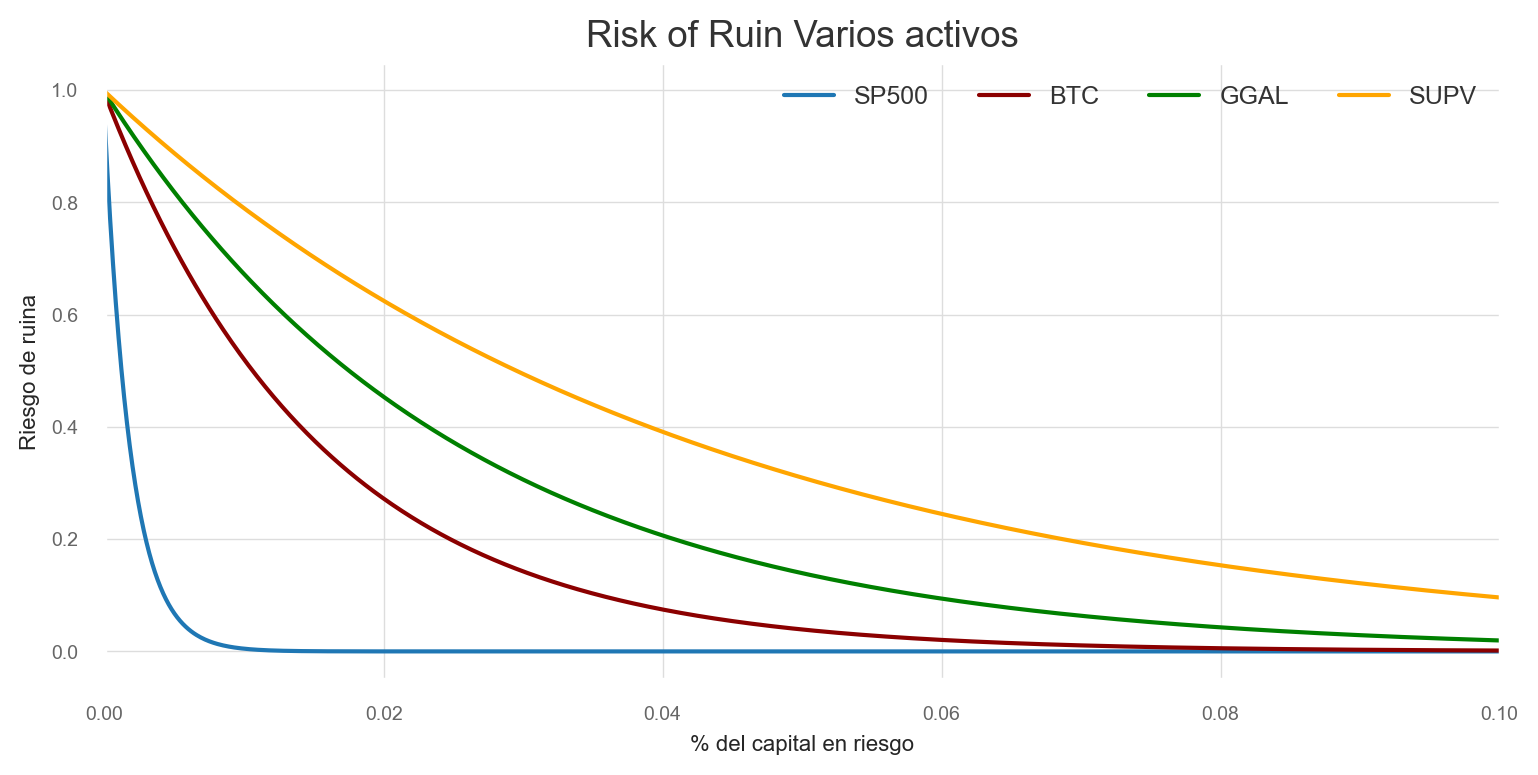

In [ ]:
plt.rcParams['figure.dpi'] = 200
fig, ax = plt.subplots(figsize=(9,4))
ax.plot(res.index/10000, res.SPY, color='tab:blue', label='SP500')
ax.plot(res.index/10000, res.BTC, color='darkred', label='BTC')
ax.plot(res.index/10000, res.GGAL, color='green', label='GGAL')
ax.plot(res.index/10000, res.SUPV, color='orange', label='SUPV')
ax.set_title( f'Risk of Ruin Varios activos')
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
ax.legend(frameon=False, fontsize=9, loc='upper right', ncols=4)
ax.set_xlabel('% del capital en riesgo', fontsize=8)
ax.set_ylabel('Riesgo de ruina', fontsize=8)
ax.set_xlim(0,0.1)
ax.grid()

## VaR

$$ \Large VaR_\alpha = -\mu + \Phi^{-1}_{1-\alpha} \cdot \sigma $$

$$ \Large VaR_\alpha = -\mu + Z_{1-\alpha} \cdot \sigma $$

* $ \Phi $ Es la CDF de la distribucion normal estandar $Z_{\mu=0,\; \sigma=1}$
* $ \Phi^{-1} $ Es la PPF de la distribucion normal estandar $Z_{\mu=0,\; \sigma=1}$
* $\mu$ y $\sigma$ son los parametros de media y desvio de la normal que estamos asumiendo
* $z$ es la probabilidad \(p\) en una distribución normal estándar $Z_{\mu=0,\; \sigma=1}$

<img src='imagenes/var_cvar.png' width=500>

### Asumiendo normalidad

In [ ]:
from scipy.stats import norm

def vaRnorm(returns, confidence=0.95):
    mu = returns.mean()
    sigma = returns.std(ddof=1)
    z = norm.ppf(confidence)
    return -mu + z*sigma

In [ ]:
vaRnorm(strategy_lin), vaRnorm(benchmark_lin)

(0.020101615840463424, 0.020101651496019897)

In [ ]:
# Es lo mismo pero fiteando la dist
# (modelo a usar para otras que no son normales)

def vaRnorm(returns, confidence=0.95):
    mu, sigma = norm.fit(returns.dropna())
    var_mod_normal = -norm.ppf(1-confidence, loc=mu, scale=sigma)
    return var_mod_normal

vaRnorm(strategy_lin), vaRnorm(benchmark_lin)

(0.020099774914935475, 0.02009984188709097)

### Usando los Valores empiricos

$$ \Large
\text{VaR}_{\alpha} = Q(1-\alpha; R)
$$

In [ ]:
def vaRemp(returns, confidence = 0.95):
    return returns.quantile(1-confidence)

In [ ]:
vaRemp(strategy_lin), vaRemp(benchmark_lin)

(-0.019058258128078872, -0.019431993741043305)

### Asumiendo JohnsonSU

La función de distribución acumulativa inversa de una distribución Johnson SU se puede expresar como:

$$ \Large
\text{VaR} \: = \: Q(p;\gamma,\delta,\xi,\lambda) = \xi + \lambda \sinh \left( \frac{z - \gamma}{\delta} \right)
$$

$$ \Large
\text{VaR} \: = \:  Q(p;\gamma,\delta,\xi,\lambda) = \xi + \lambda \sinh \left( \frac{\Phi^{-1}(p) - \gamma}{\delta} \right)
$$


Donde:

* $Q(p;\gamma,\delta,\xi,\lambda)$ es la función de distribución acumulativa inversa de la distribución Johnson SU
* $p$ es la probabilidad (nivel de confianza requerido)
* $\gamma$, $\delta$, $\xi$, y $\lambda$ son los parámetros de la distribución Johnson SU
* $z$ es el valor z correspondiente a la probabilidad \(p\) en una distribución normal estándar

In [ ]:
from scipy.stats import johnsonsu

def vaRjSU(returns, confidence=0.95):
    gamma, delta, xi, lambda_ = johnsonsu.fit(returns.dropna())
    return johnsonsu.ppf(1-confidence, gamma, delta, xi, lambda_)

In [ ]:
vaRjSU(strategy_lin), vaRjSU(benchmark_lin)

(-0.019022925745796646, -0.01873255329646102)

### Resumen VaR

In [ ]:
def vaR(returns, confidence=0.95):
    var_emp = vaRemp(returns, confidence)
    var_mod_normal = vaRnorm(returns, confidence)
    var_mod_jsu = vaRjSU(returns, confidence)
    return {"Empirico": var_emp, "Modelado Normal": var_mod_normal,
            "Modelado JohnsonSU": var_mod_jsu}

In [ ]:
vaR(strategy_lin)

{'Empirico': -0.019058258128078872,
 'Modelado Normal': 0.020099774914935475,
 'Modelado JohnsonSU': -0.019022925745796646}

In [ ]:
vaR(benchmark_lin)

{'Empirico': -0.019431993741043305,
 'Modelado Normal': 0.02009984188709097,
 'Modelado JohnsonSU': -0.01873255329646102}

In [ ]:
confidence = 0.95

summ = zip(vaR(strategy_lin, confidence).values(),
           vaR(benchmark_lin, confidence).values())

cols = ['Strategy','Benchmark']
rows = ['Empírico %','Modelado Normal %','Modelado JohnsonSU %']
pd.DataFrame(summ, index=rows, columns=cols).mul(100).round(2).T

,Empírico %,Modelado Normal %,Modelado JohnsonSU %
Strategy,-1.91,2.01,-1.90
Benchmark,-1.94,2.01,-1.87


In [ ]:
confidence = 0.99

summ = zip(vaR(strategy_lin, confidence).values(),
           vaR(benchmark_lin, confidence).values())

cols = ['Strategy','Benchmark']
rows = ['Empírico %','Modelado Normal %','Modelado JohnsonSU %']
pd.DataFrame(summ, index=rows, columns=cols).mul(100).round(2).T

,Empírico %,Modelado Normal %,Modelado JohnsonSU %
Strategy,-3.54,2.87,-3.65
Benchmark,-3.48,2.86,-3.89


In [ ]:
tickers = ['AAPL','MSFT','GOOGL','AMZN','PG','V','KO','MCD','JNJ','SPY','QQQ','DIA','TLH','AGG','BND']
tickers_px = yf.download(tickers, start='2013-01-01', auto_adjust=True).Close
tickers_returns = tickers_px.pct_change()
vars = []
for ticker in tickers:
    vars.append(vaR(tickers_returns[ticker].dropna(), confidence=0.99))

vars_df = pd.DataFrame(vars, index=tickers).abs().mul(100)

[*********************100%%**********************]  15 of 15 completed


In [ ]:
vars_df['Modelado Normal Error'] = vars_df['Modelado Normal'] - vars_df['Empirico']
vars_df['Modelado JohnsonSU Error'] = vars_df['Modelado JohnsonSU'] - vars_df['Empirico']
vars_df

,Empirico,Modelado Normal,Modelado JohnsonSU,Modelado Normal Error,Modelado JohnsonSU Error
AAPL,4.797308,4.033459,4.874751,-0.763849,0.077444
MSFT,4.239829,3.778895,4.520505,-0.460934,0.280676
GOOGL,4.659421,3.934192,4.902145,-0.725229,0.242723
AMZN,5.617912,4.642461,5.606134,-0.975451,-0.011778
PG,3.265072,2.573777,3.017428,-0.691295,-0.247644
V,4.191229,3.451374,4.351700,-0.739855,0.160471
KO,3.155588,2.524794,3.092981,-0.630794,-0.062607
MCD,2.977690,2.784707,3.138543,-0.192983,0.160853
JNJ,2.903887,2.523895,3.023470,-0.379992,0.119582
SPY,3.026701,2.406997,3.073143,-0.619704,0.046442


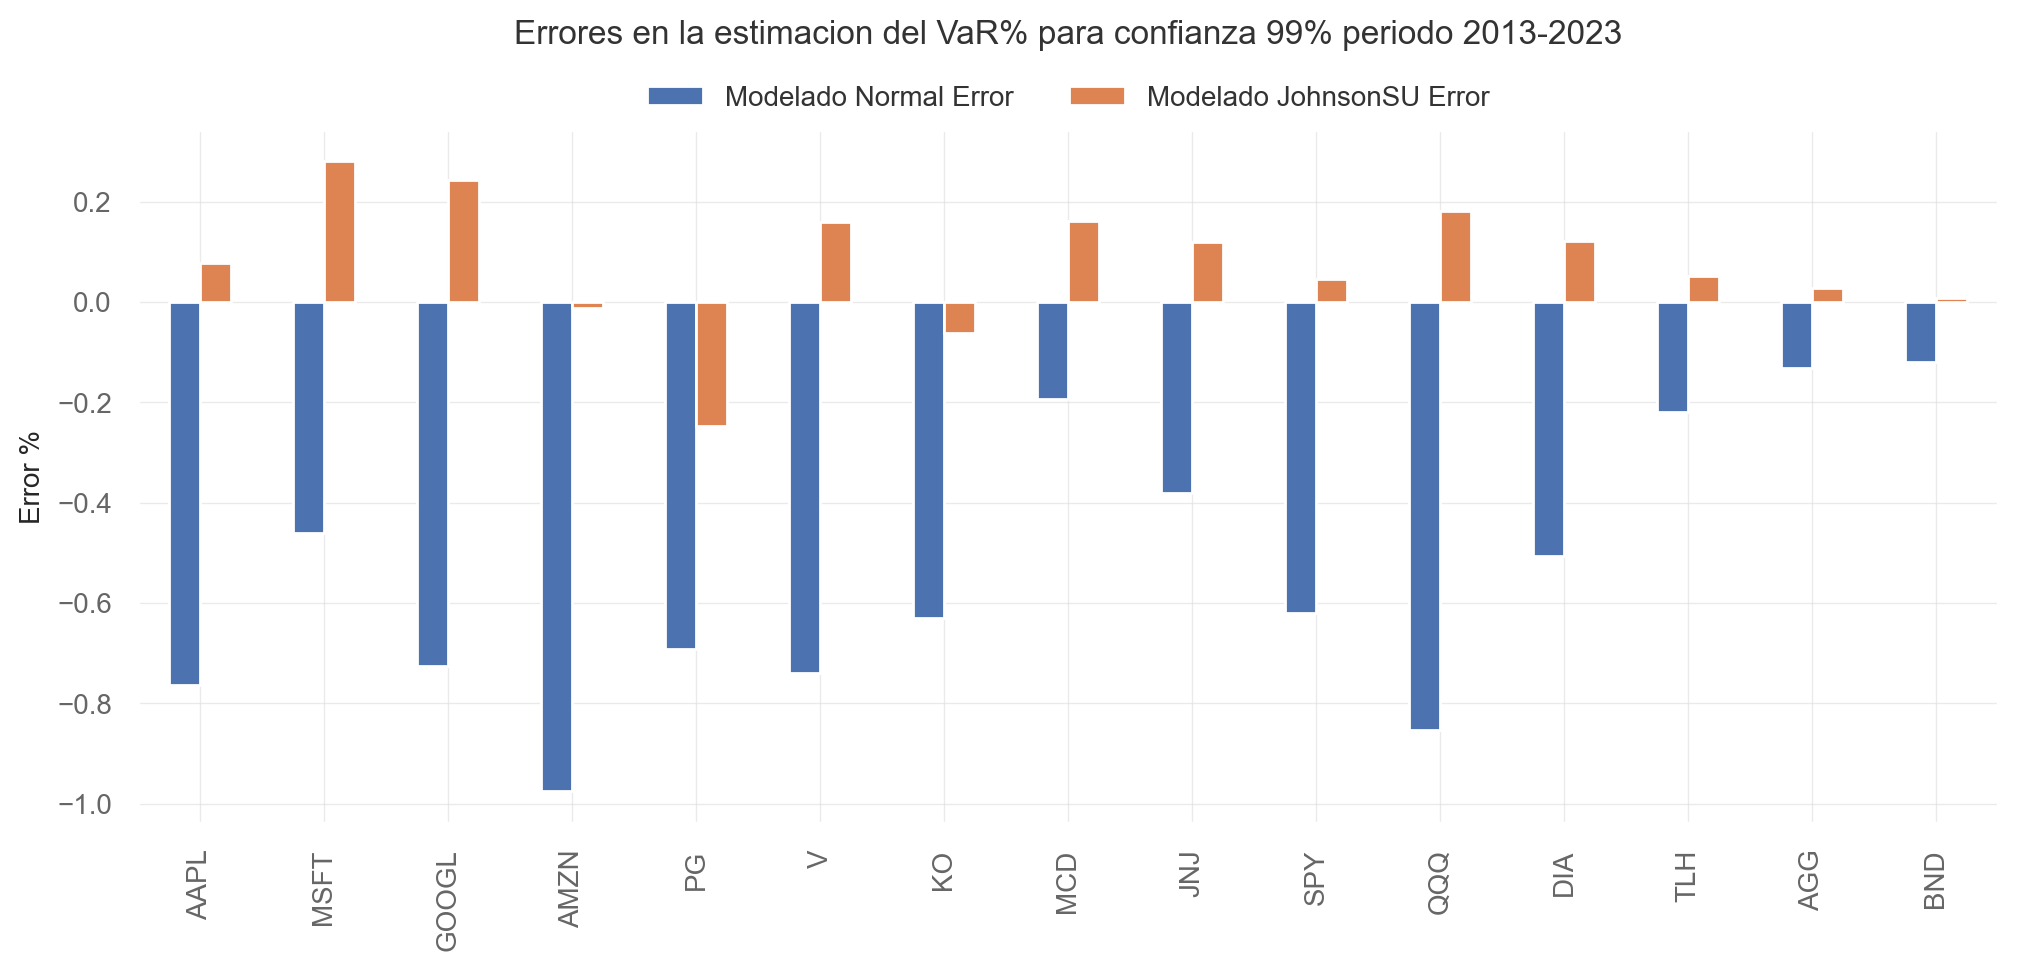

In [ ]:
fig, ax = plt.subplots(figsize=(12,4.5))
vars_df.iloc[:,-2:].plot(kind='bar', ax=ax)
ax.legend(frameon=False, loc='upper center', ncols=2, fontsize=10, bbox_to_anchor=(0.5,1.1))
ax.set_title('Errores en la estimacion del VaR% para confianza 99% periodo 2013-2023', fontsize=12, y=1.1)
ax.set_ylabel('Error %', fontsize=10)
ax.tick_params(axis='both', labelsize=10)
ax.grid(alpha=0.6)

## cVaR (valor en riesgo condicional)  - Expected Shortfall

$$ \large \text{CVaR}_{1-\alpha }(X)={\frac {1}{\alpha }}\int _{0}^{\alpha }{\text{VaR}}_{1-\gamma }(X)d\gamma  $$

### Modelado con normal

$$  {\large \operatorname {ES} _{\alpha }(X)= \: -\mu +\sigma {\frac {\varphi (\Phi ^{-1}(\alpha ))}{\alpha }}} $$

$\varphi$ es la normal(0,1)

$$ \Large \varphi(z) = \frac{1}{\sqrt{2\pi}} e^{-\frac{1}{2}z^2} $$

$$ \Large Z \sim N(0,1) \implies \Phi^{-1}(p) = z \iff P(Z \leq z) = p $$

* $ \varphi $ Es la PDF de la distribucion normal ($\mu=0$, $\sigma=1$)
* $ \Phi $ Es la CDF de la distribucion normal ($\mu=0$, $\sigma=1$)
* $ \Phi^{-1} $ Es la PPF de la distribucion normal ($\mu=0$, $\sigma=1$)
* $\alpha$ es el nivel de confianza

In [ ]:
mu = strategy_lin.mean()
sigma = strategy_lin.std()

mu_bench = benchmark_lin.mean()
sigma_bench = benchmark_lin.std()

In [ ]:
confidence = 0.99
cVar_mod_norm = -mu + sigma * norm.pdf(norm.cdf(1-confidence)**-1)/(1-confidence)
print(f"cVaR Estrategia Modelado Normal: {cVar_mod_norm:.2%}")

cVaR Estrategia Modelado Normal: 6.97%


In [ ]:
cVar_mod_norm = -mu_bench + sigma_bench * norm.pdf(norm.cdf(1-confidence)**-1)/(1-confidence)
print(f"cVaR Benchmark Modelado Normal: {cVar_mod_norm:.2%}")

cVaR Benchmark Modelado Normal: 6.89%


In [ ]:
def cVaRnorm(returns, confidence=0.99):
    alpha = 1- confidence
    mu, sigma = returns.mean(), returns.std()
    return -mu + sigma * norm.pdf(norm.cdf(alpha)**-1)/(alpha)

In [ ]:
cVaRnorm(strategy_lin), cVaRnorm(benchmark_lin)

(0.06974067588246523, 0.06889628490909498)

### cVaR Empirico

Partimos de la base del VaR empírico para un nivel de confianza alpha

$$
VaR_{\alpha} = Q(1-\alpha; X)
$$

Luego, definimos la "cola" de la distribución como los retornos que son menores que el VaR:

$$
T = \{x \in X : x < VaR_{\alpha}\}
$$

Finalmente, calculamos el CVaR como el valor esperado (media) de los retornos en la cola de la distribución:

$$
CVaR_{\alpha} = -\frac{1}{n(T)} \sum_{x \in T} x
$$


In [ ]:
var_emp = vaRemp(strategy_lin, confidence=0.99)
tail = strategy_lin.loc[strategy_lin < var_emp].tolist()
cVar_emp = -np.mean(np.array(tail))
print(f"cVaR Empirico Estrategia: {cVar_emp:.2%}")

cVaR Empirico Estrategia: 4.99%


In [ ]:
var_emp = vaRemp(benchmark_lin, confidence=0.99)
tail = benchmark_lin.loc[benchmark_lin < var_emp].tolist()
cVar_emp = -np.mean(np.array(tail))
print(f"cVaR Empirico Benchmark: {cVar_emp:.2%}")

cVaR Empirico Benchmark: 5.00%


In [ ]:
def cVaRemp(returns, confidence=0.99):
    var_emp = vaRemp(returns, confidence)
    tail = returns.loc[returns < var_emp].tolist()
    cVar_emp = -np.mean(np.array(tail))
    return cVar_emp

In [ ]:
cVaRemp(strategy_lin), cVaRemp(benchmark_lin)

(0.04986711012613309, 0.049957829329694066)

### cVaR Modelado con johnsonSU

$$ {\large \operatorname {ES} _{\alpha }(X)=-\xi -{\frac {\lambda }{2\alpha }}\left[\exp \left({\frac {1-2\gamma \delta }{2\delta ^{2}}}\right)\;\Phi \left(\Phi ^{-1}(\alpha )-{\frac {1}{\delta }}\right)-\exp \left({\frac {1+2\gamma \delta }{2\delta ^{2}}}\right)\;\Phi \left(\Phi ^{-1}(\alpha )+{\frac {1}{\delta }}\right)\right]} $$

In [ ]:
def cVaRjSU(returns, confidence=0.99):
    gamma, delta, xi, lambda_ = johnsonsu.fit(returns.dropna())
    mu, sigma = returns.mean(), returns.std()
    CDF = norm(0,1).cdf
    PPF = norm(0,1).ppf
    alpha = 1-confidence
    cVar_jSU = -xi - (lambda_ / (2 * alpha)) * (
        np.exp((1 - 2 * gamma * delta) / (2 * delta**2)) * CDF(PPF(alpha) - (1 / delta))
        - np.exp((1 + 2 * gamma * delta) / (2 * delta**2)) * CDF(PPF(alpha) + (1 / delta))
    )
    return cVar_jSU

In [ ]:
cVaRjSU(strategy_lin), cVaRjSU(benchmark_lin)

(0.05149473738292471, 0.058158889744648806)

### Resumen cVaR

In [ ]:
def cVaR(returns, confidence=0.95):
    cvar_emp = cVaRemp(returns, confidence)
    cvar_mod_normal = cVaRnorm(returns, confidence)
    cvar_mod_jsu = cVaRjSU(returns, confidence)
    return {"Empirico": cvar_emp, "Modelado Normal": cvar_mod_normal,
            "Modelado JohnsonSU": cvar_mod_jsu}

In [ ]:
confidence = 0.95

summ = zip(cVaR(strategy_lin, confidence).values(),
           cVaR(benchmark_lin, confidence).values())

cols = ['Strategy','Benchmark']
rows = ['Empírico %','Modelado Normal %','Modelado JohnsonSU %']
pd.DataFrame(summ, index=rows, columns=cols).mul(100).round(2).T

,Empírico %,Modelado Normal %,Modelado JohnsonSU %
Strategy,3.03,1.52,3.04
Benchmark,2.99,1.53,3.21


In [ ]:
confidence = 0.99

summ = zip(cVaR(strategy_lin, confidence).values(),
           cVaR(benchmark_lin, confidence).values())

cols = ['Strategy','Benchmark']
rows = ['Empírico %','Modelado Normal %','Modelado JohnsonSU %']
pd.DataFrame(summ, index=rows, columns=cols).mul(100).round(2).T

,Empírico %,Modelado Normal %,Modelado JohnsonSU %
Strategy,4.99,6.97,5.15
Benchmark,5.00,6.89,5.82


In [ ]:
cvars = []
for ticker in tickers:
    cvars.append(cVaR(tickers_returns[ticker].dropna(), confidence=0.99))

cvars_df = pd.DataFrame(cvars, index=tickers).abs().mul(100)

In [ ]:
cvars_df['Modelado Normal Error'] = cvars_df['Modelado Normal'] - cvars_df['Empirico']
cvars_df['Modelado JohnsonSU Error'] = cvars_df['Modelado JohnsonSU'] - cvars_df['Empirico']
cvars_df

,Empirico,Modelado Normal,Modelado JohnsonSU,Modelado Normal Error,Modelado JohnsonSU Error
AAPL,6.628320,9.805179,6.751507,3.176859,0.123188
MSFT,6.040718,9.210042,6.318546,3.169324,0.277828
GOOGL,6.069024,9.549450,6.909586,3.480426,0.840562
AMZN,7.458199,11.271797,7.826441,3.813598,0.368242
PG,4.641223,6.233105,4.207254,1.591882,-0.433969
V,5.606048,8.378773,6.141508,2.772725,0.535460
KO,4.862698,6.102640,4.385446,1.239942,-0.477252
MCD,4.902708,6.748761,4.390788,1.846053,-0.511920
JNJ,4.404895,6.108688,4.197913,1.703792,-0.206982
SPY,4.379456,5.844976,4.485125,1.465520,0.105669


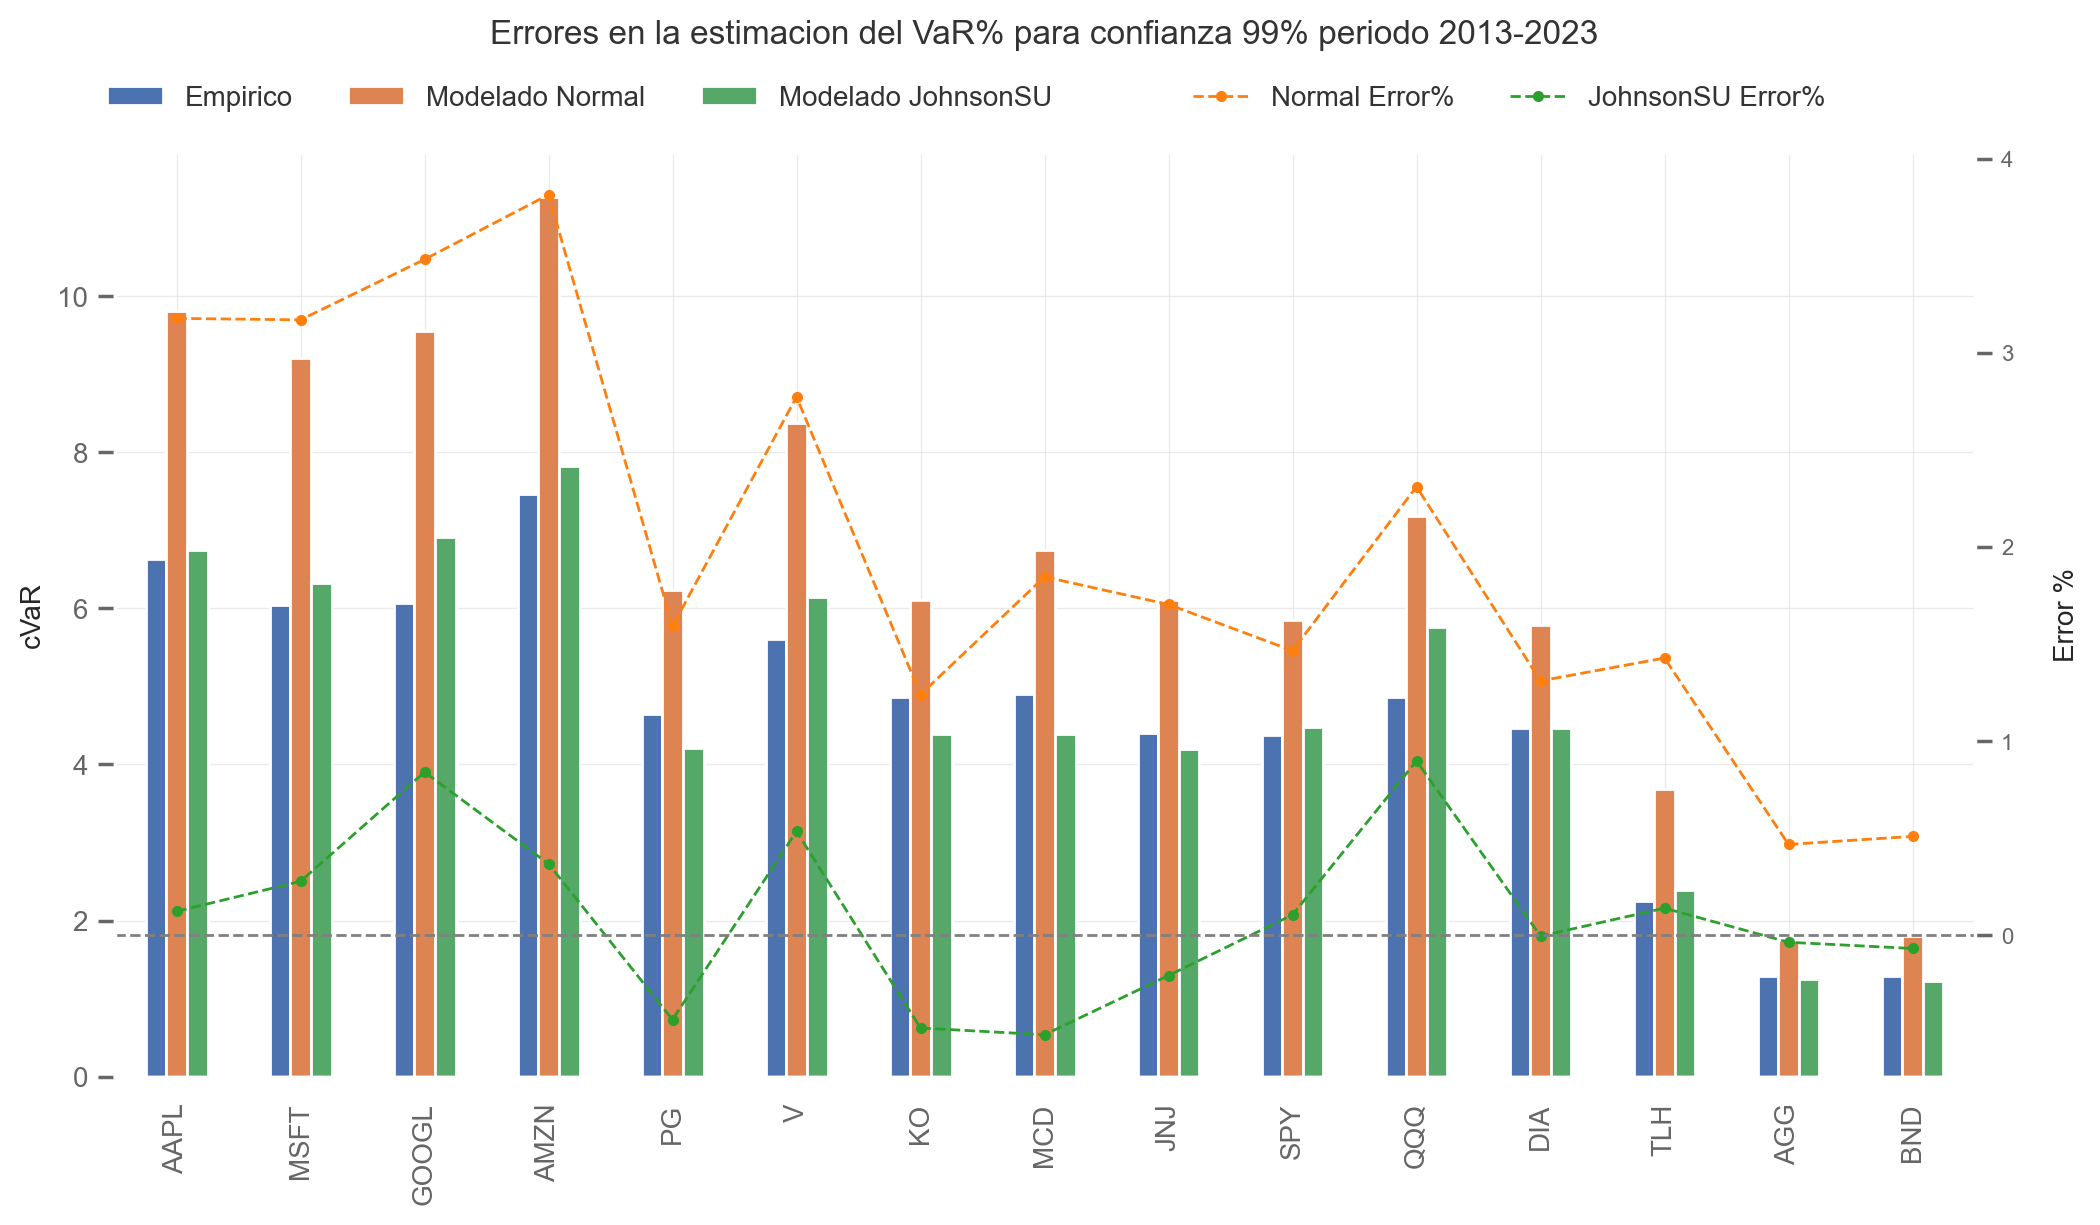

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
cvars_df.iloc[:,:-2].plot(kind='bar', ax=ax)
ax2 = ax.twinx()
ax2.plot(cvars_df['Modelado Normal Error'],c='tab:orange',ls='--', lw=1, marker='.', label='Normal Error%')
ax2.plot(cvars_df['Modelado JohnsonSU Error'],c='tab:green',ls='--', lw=1, marker='.', label='JohnsonSU Error%')
ax.legend(frameon=False, loc='upper center', ncols=3, fontsize=10, bbox_to_anchor=(0.25,1.1))
ax2.legend(frameon=False, loc='upper center', ncols=2, fontsize=10, bbox_to_anchor=(0.75,1.1))
ax2.axhline(0, ls='--', c='gray', lw=1)
ax.set_title('Errores en la estimacion del VaR% para confianza 99% periodo 2013-2023', fontsize=12, y=1.1)
ax.set_ylabel('cVaR', fontsize=10)
ax2.set_ylabel('\nError %', fontsize=10)
ax2.tick_params(axis='y', labelsize=8)
ax.tick_params(axis='both', labelsize=10)
ax.grid(alpha=0.6)

## PayOff Ratio

Separamos los retornos en ganadores y perdedores:

$$
W = \{x \in X : x > 0\}
\quad,\quad
L = \{x \in X : x < 0\}
$$

Calculamos la media de los ganadores y los perdedores:

$$
\mu_W = \frac{1}{n(G)} \sum_{x \in W} x
\quad,\quad
\mu_L = \frac{1}{n(P)} \sum_{x \in L} x
$$

Calculamos el ratio de beneficio como la media de los ganadores dividida por el valor absoluto de la media de los perdedores:

$$
\text{Payoff Ratio} = -\frac{\mu_W}{\mu_L}
$$


- Asimetría dias/trades Ganadores/Perdedores
- No tiene en cuenta cantidad de cada uno, solo ratio en las medias de los ganadores/perdedores

In [ ]:
def payoff_ratio(log_returns):
    perdedores = log_returns[log_returns < 0]
    ganadores = log_returns[log_returns > 0]
    payoff_ratio = -ganadores.mean() / perdedores.mean()
    return payoff_ratio

In [ ]:
payoff_ratio(strategy_log), payoff_ratio(benchmark_log)

(0.9505283349128915, 0.8865050622175532)

In [ ]:
def payoff_summary(strategy, benchmark, timeframe='D'):

    strategy = strategy.resample(timeframe).last()
    benchmark = benchmark.resample(timeframe).last()
    strategy_log = np.log (strategy / strategy.shift())
    benchmark_log = np.log (benchmark / benchmark.shift())

    perdedores_st = strategy_log[strategy_log < 0]
    ganadores_st = strategy_log[strategy_log > 0]

    perdedores_bench = benchmark_log[benchmark_log < 0]
    ganadores_bench = benchmark_log[benchmark_log > 0]

    st = -ganadores_st.mean() / perdedores_st.mean()
    bench = -ganadores_bench.mean() / perdedores_bench.mean()

    st_q = len(ganadores_st)/len(perdedores_st)
    bench_q = len(ganadores_bench)/len(perdedores_bench)

    st_p = st * st_q
    bench_p = bench * bench_q

    cols = ['Strategy','Benchmark']
    rows = ['Win/Loss mean','Win/Loss quantity','Prod']
    df = pd.DataFrame(data=[[st,st_q,st_p],[bench,bench_q,bench_p]], columns=rows, index=cols).round(2)
    return df

In [ ]:
payoff_summary(strategy, benchmark, timeframe='D')

,Win/Loss mean,Win/Loss quantity,Prod
Strategy,0.96,1.21,1.16
Benchmark,0.89,1.22,1.08


In [ ]:
payoff_summary(strategy, benchmark, timeframe='W')

,Win/Loss mean,Win/Loss quantity,Prod
Strategy,0.98,1.39,1.35
Benchmark,0.90,1.28,1.15


In [ ]:
payoff_summary(strategy, benchmark, timeframe='M')

,Win/Loss mean,Win/Loss quantity,Prod
Strategy,1.13,1.72,1.95
Benchmark,0.78,1.73,1.35


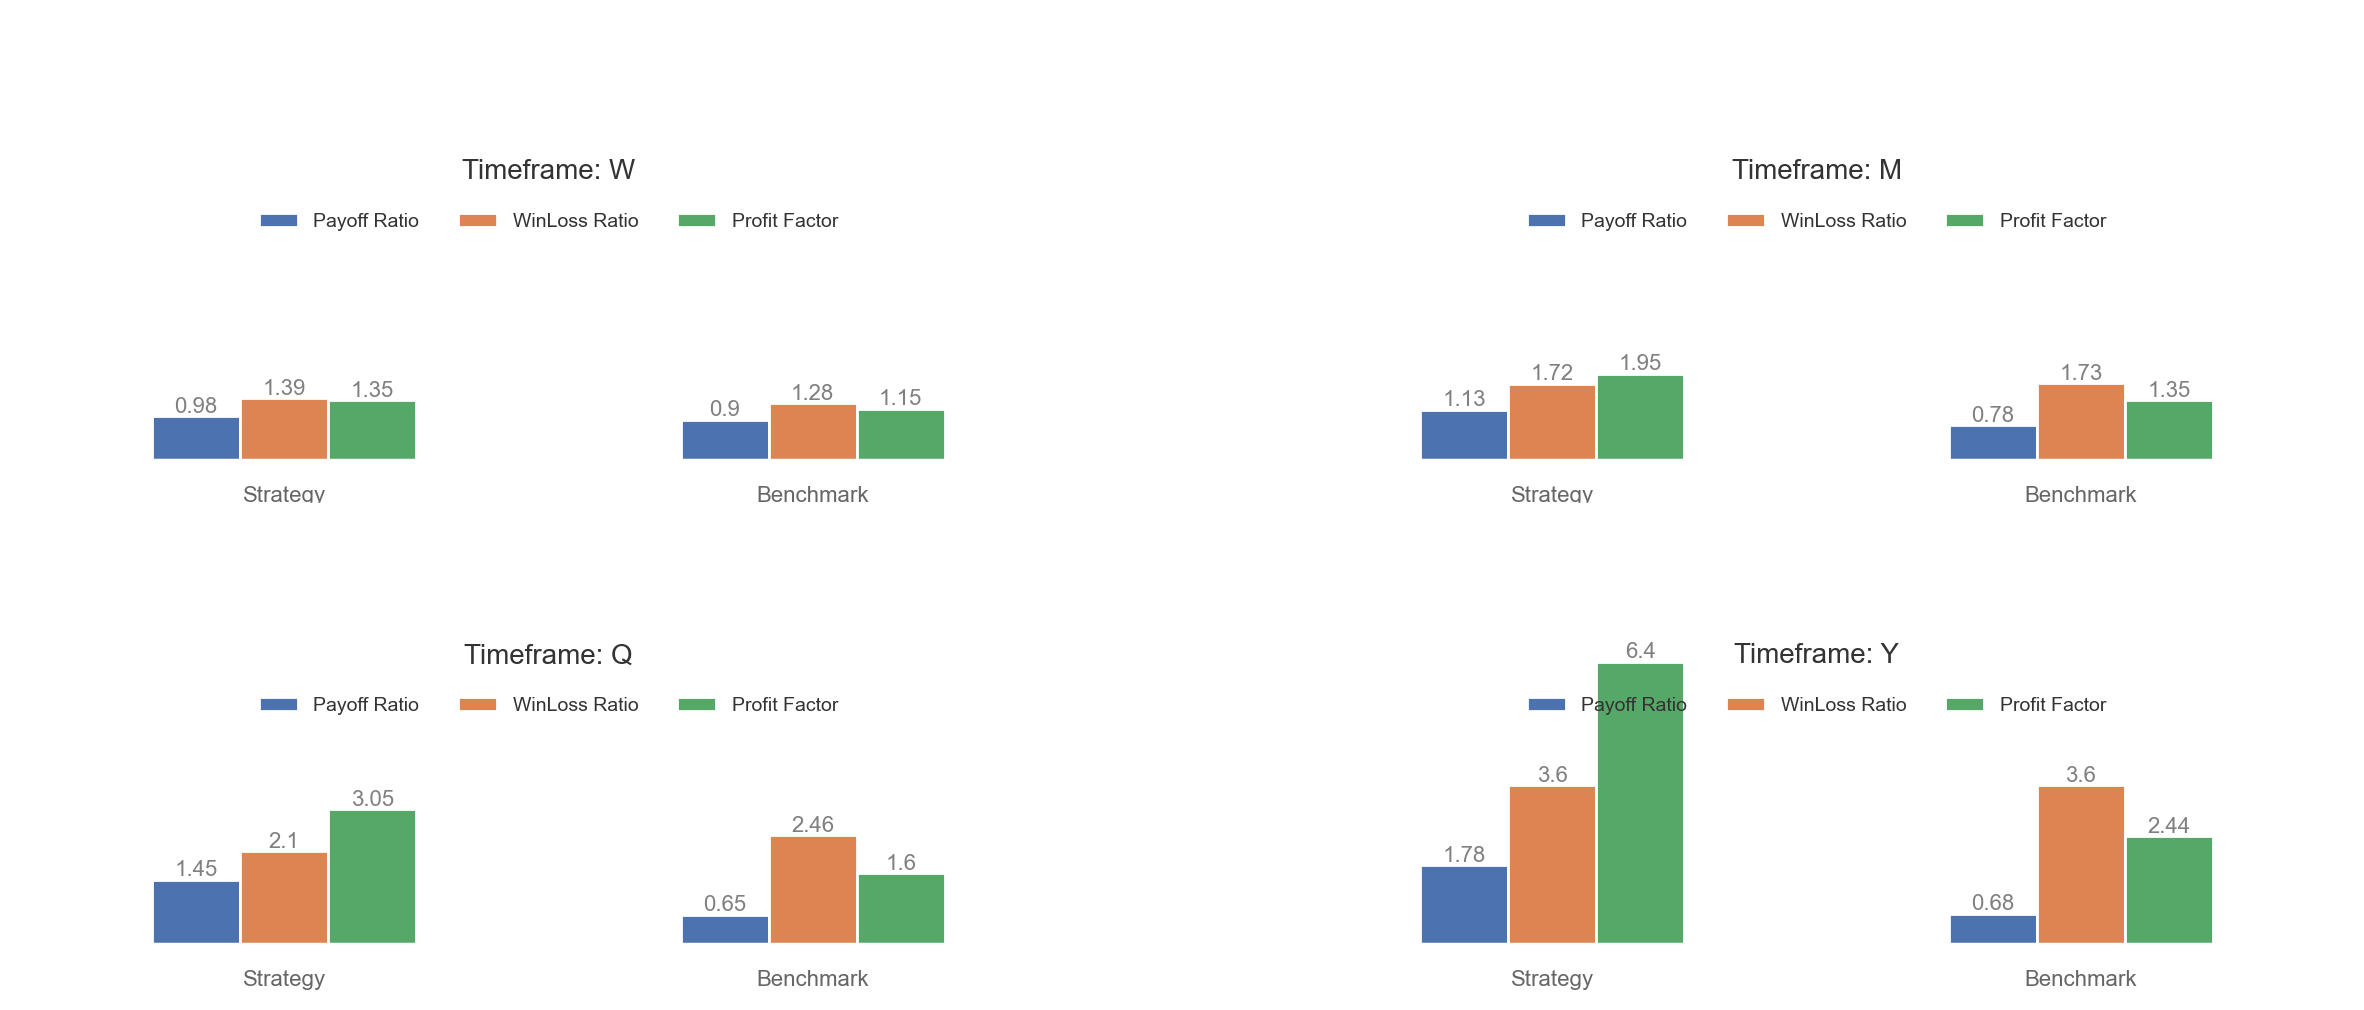

In [ ]:
timeframes = ['W','M','Q','Y']
fig, ax = plt.subplots(figsize=(15,6), ncols=2, nrows=2)
for i in range(4):
    col = i%2
    row = i//2
    bars = payoff_summary(strategy, benchmark, timeframe=timeframes[i]).plot(kind='bar', ax=ax[row][col])
    ax[row][col].set_ylim(0,10)
    ax[row][col].tick_params(axis='x', labelsize=8,rotation=0)
    labels = ['Payoff Ratio', 'WinLoss Ratio', 'Profit Factor']
    ax[row][col].legend(labels, loc='upper center', frameon=False, fontsize=7, ncols=3, bbox_to_anchor=(0.5,0.6))
    ax[row][col].set_yticks([])
    ax[row][col].set_title(f'Timeframe: {timeframes[i]}', fontsize=10, y=0.6)
    for bar in bars.patches:
        ax[row][col].text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                          round(bar.get_height(), 2), fontsize=8, color='gray',
                          ha='center', va='bottom')
plt.subplots_adjust(hspace=0.1)

## Profit Factor

- Ganancias TOTALES sobre perdidas totales

Separamos los retornos en ganadores y perdedores:

$$
W = \{x \in X : x > 0\}
\quad , \quad
L = \{x \in X : x < 0\}
$$

Calculamos la suma de los ganadores y los perdedores:

$$
Ws = \sum_{x \in W} x
\quad , \quad
Ls = \sum_{x \in L} x
$$

Ratio: Profit factor:

$$
\text{Profit Factor} = -\frac{Ws}{Ls}
$$


In [ ]:
perdedores_st = strategy_log[strategy_log < 0]
ganadores_st = strategy_log[strategy_log > 0]

perdedores_bench = benchmark_log[benchmark_log < 0]
ganadores_bench = benchmark_log[benchmark_log > 0]

profit_factor_st = -ganadores_st.sum() / perdedores_st.sum()
profit_factor_bench = -ganadores_bench.sum() / perdedores_bench.sum()

profit_factor_st, profit_factor_bench

(1.1486634942826885, 1.0651240399335313)

In [ ]:
def profitFactor(log_returns):
    perdedores = log_returns[log_returns < 0]
    ganadores = log_returns[log_returns > 0]
    profit_factor = -ganadores.sum() / perdedores.sum()
    return profit_factor

In [ ]:
profitFactor(strategy_log), profitFactor(benchmark_log)

(1.1486634942826885, 1.0651240399335313)

### WinLoss Ratio

Separamos los retornos en ganadores y perdedores:

$$
W = \{x \in X : x > 0\}
\quad , \quad
L = \{x \in X : x < 0\}
$$

Calculamos la cardinalidad o número de ganadores y perdedores:

$$
nW = |W|
\quad , \quad
nL = |L|
$$

Ratio de ganancias y pérdidas como el número de ganadores dividido por el número de perdedores:

$$
\text{Win Loss Ratio} = \frac{nW}{nL}
$$


In [ ]:
def win_loss_ratio(log_returns):
    perdedores = log_returns[log_returns < 0]
    ganadores = log_returns[log_returns > 0]
    win_loss_ratio = ganadores.count() / perdedores.count()
    return win_loss_ratio

In [ ]:
po_r = payoff_ratio(tickers_returns)
wl_r = win_loss_ratio(tickers_returns)

ratios = pd.DataFrame([po_r,wl_r], index=['Payoff Ratio','WinLoss Ratio']).T
ratios['ProfitFactor Ratio'] = profitFactor(tickers_returns)
ratios

,Payoff Ratio,WinLoss Ratio,ProfitFactor Ratio
Ticker,,,
AAPL,1.053858,1.118632,1.178879
AGG,0.934863,1.140835,1.066524
AMZN,1.021777,1.140338,1.165171
BND,0.943461,1.131934,1.067936
DIA,0.942097,1.235204,1.163682
GOOGL,1.027845,1.130848,1.162336
JNJ,1.018036,1.105951,1.125897
KO,0.976081,1.137880,1.110663
MCD,0.996420,1.155902,1.151764


## Rachev ratio (Tails ratios)

### Approach A (usando ratio de cuantiles)

Calculamos los cuantiles de orden $\alpha$ y $1-\alpha$ de la distribución de retornos:

$$
Q_{\alpha} = F^{-1}(\alpha)
\quad , \quad
Q_{1-\alpha} = F^{-1}(1-\alpha)
$$

- $ F^{-1} $ es la función de distribución acumulativa inversa de la distribución de retornos
- $ Q_{\alpha} $ es el cuantil de orden $ \alpha $ de la distribución de retornos
    <br>El valor tal que la probabilidad de que un retorno sea menor o igual a $ Q_{\alpha} $ es $ \alpha $
- $ Q_{1-\alpha} $ es el cuantil de orden $ 1-\alpha $ de la distribución de retornos
    <br>El valor tal que la probabilidad de que un retorno sea menor o igual a $ Q_{1-\alpha} $ es $ 1-\alpha $

El ratio Rachev es el cuantil de orden $1-\alpha$ dividido por el valor absoluto del cuantil de orden $\alpha$:

$$
\Large \text{Rachev}_A = \frac{Q_{1-\alpha}}{|Q_{\alpha}|}
$$


In [ ]:
def rachevA(returns, alpha=0.05):
    right_tail = returns.quantile(1-alpha)
    left_tail = abs(returns.quantile(alpha))
    rachev = right_tail / left_tail
    return rachev

In [ ]:
rachevA(strategy_log), rachevA(benchmark_log)

(0.9888569504987804, 0.8897718115767888)

In [ ]:
# Muchos toman retornos lineales, pero no es correcto, por tema de asimetria deben usarse logaritmicos
rachevA(strategy_lin), rachevA(benchmark_lin)

(1.0079605786768682, 0.9064206226621847)

### Approach B (promediando las colas)

Calculamos los cuantiles de orden $\alpha$ y $1-\alpha$ de la distribución de retornos:

$$
Q_{\alpha} = F^{-1}(\alpha)
\quad , \quad
Q_{1-\alpha} = F^{-1}(1-\alpha)
$$

Separamos los retornos en aquellos que son menores que el cuantil de orden $1-\alpha$ (cola izquierda) y aquellos que son mayores que el cuantil de orden $\alpha$ (cola derecha):

$$
R_{\alpha} = \{x \in X : x < Q_{\alpha}\}
\quad , \quad
R_{1-\alpha} = \{x \in X : x > Q_{1-\alpha}\}
$$

Calculamos el promedio de los retornos en cada uno de estos conjuntos:

$$
\bar{R}_{\alpha} = \frac{1}{|R_{\alpha}|} \sum R_{\alpha}
\quad , \quad
\bar{R}_{1-\alpha} = \frac{1}{|R_{1-\alpha}|} \sum R_{1-\alpha}
$$

Rachev con este approach es el promedio de los retornos que son menores que el cuantil de orden $1-\alpha$ dividido por el promedio de los retornos que son mayores que el cuantil de orden $\alpha$:

$$
\Large \text{Rachev}_B = \frac{-\bar{R}_{1-\alpha}}{\bar{R}_{\alpha}}
$$

- $ F^{-1} $ es la función de distribución acumulativa inversa de la distribución de retornos
- $ Q_{\alpha} $ es el cuantil de orden $ \alpha $ de la distribución de retornos
    <br>El valor tal que la probabilidad de que un retorno sea menor o igual a $ Q_{\alpha} $ es $ \alpha $
- $ Q_{1-\alpha} $ es el cuantil de orden $ 1-\alpha $ de la distribución de retornos
    <br>El valor tal que la probabilidad de que un retorno sea menor o igual a $ Q_{1-\alpha} $ es $ 1-\alpha $

- $ R_{\alpha} $ es el conjunto de retornos que son menores que el cuantil de orden $ \alpha $
- $ R_{1-\alpha} $ es el conjunto de retornos que son mayores que el cuantil de orden $ 1-\alpha $
- $ X $ es el conjunto de todos los retornos

In [ ]:
def rachevB(returns, alpha=0.05):
    right_tail = returns.quantile(1-alpha)
    left_tail = returns.quantile(alpha)
    right_tail_returns = returns[returns > right_tail]
    left_tail_returns = returns[returns < left_tail]
    rachevB = - right_tail_returns.mean() / left_tail_returns.mean()
    return rachevB

In [ ]:
rachevB(strategy_log), rachevB(benchmark_log)

(0.9204185711166671, 0.9156005154261286)

### Approach C (con las áreas)

Similar al approach B, pero en lugar de tomar los promedios tomamos un promedio ponderado por la funcion de probabilidades PDF

$$
S_{\alpha} = \sum \varphi(R_{\alpha}) R_{\alpha}
\quad , \quad
S_{1-\alpha} = \sum \varphi(R_{1-\alpha}) R_{1-\alpha}
$$

- $ \varphi $ es la función de densidad (PDF) de probabilidad de la distribución normal estándar


Y calculamos el coeficiente de Rachev como la suma ponderada de los retornos que son mayores que el cuantil de orden $ 1-\alpha $ dividido por la suma ponderada de los retornos que son menores que el cuantil de orden $ \alpha $:

$$
\Large \text{Rachev}_C = \frac{S_{1-\alpha}}{S_{\alpha}}
$$

In [ ]:
from scipy.stats import norm

def rachevC(returns, alpha=0.05):
    dist = returns
    qL, qR = dist.quantile(alpha), dist.quantile(1-alpha)
    L = [abs(x) for x in dist if x < qL]
    R = [x for x in dist if x > qR]
    rachevC = (norm.pdf(R)*R).sum()/(norm.pdf(L)*L).sum()
    return rachevC



In [ ]:
rachevC(strategy_log), rachevC(benchmark_log)

(0.9206543672280117, 0.9156456551989486)

### Representación Gráfica

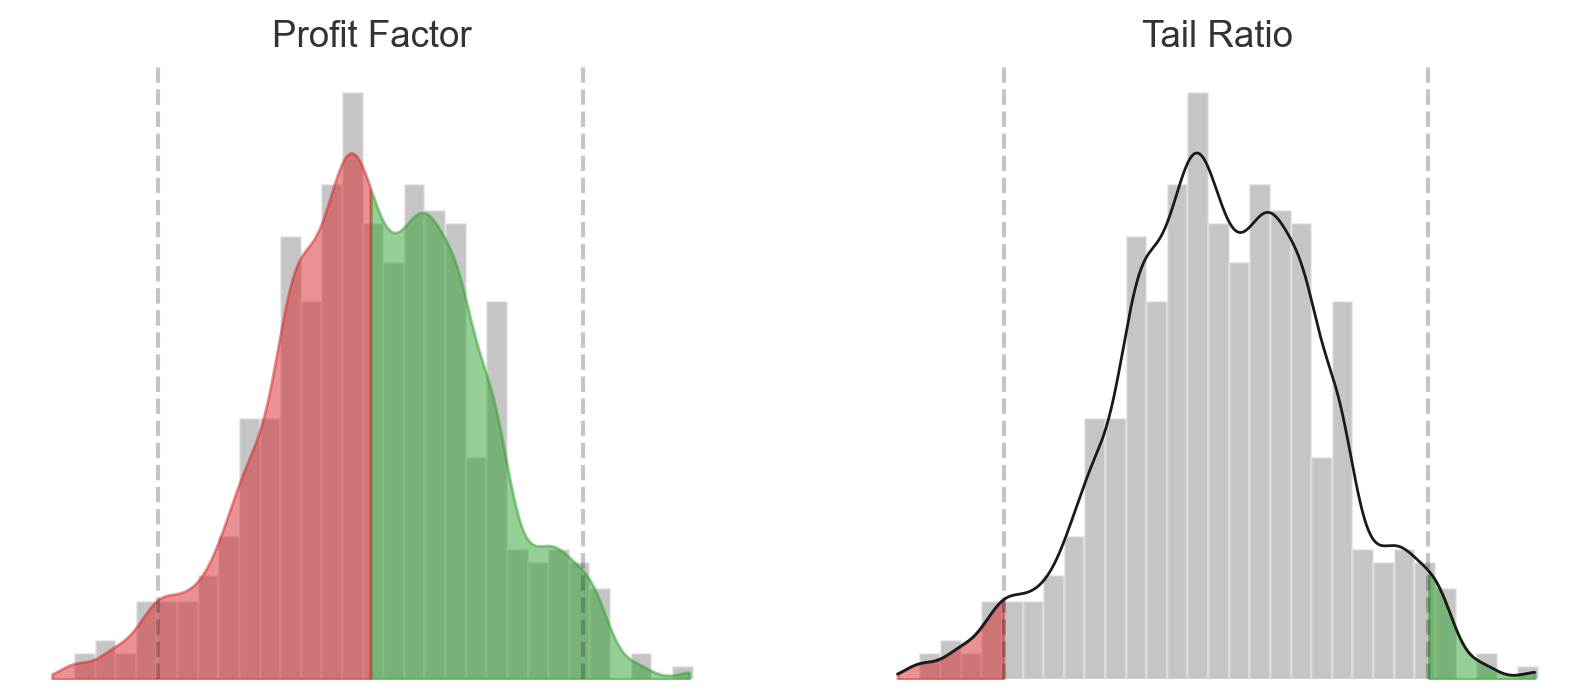

In [ ]:
from scipy.stats import norm, gaussian_kde
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,4), ncols=2)

np.random.seed(1)

# Armo distribucion aleatoria
dist = pd.Series(norm(0,1).rvs(500))

# Genero un kernel de funcion de densidad
kde = gaussian_kde(dist, bw_method=0.15)

# Genero puntos del eje x equidistantes
x = np.linspace(-3, 3, 1000)

ax[0].hist(dist, density=True, bins=30, color='k', alpha=0.25)
ax[0].fill_between(x, kde(x), where=x>0, color='tab:green', alpha=0.5)
ax[0].fill_between(x, kde(x), where=x<0, color='tab:red', alpha=0.5)
ax[0].set_title('Profit Factor')

ax[1].plot(x, kde(x), '-k', lw=1)
ax[1].hist(dist, density=True, bins=30, color='k', alpha=0.25)
ax[1].fill_between(x, kde(x), where=x>2, color='tab:green', alpha=0.5)
ax[1].fill_between(x, kde(x), where=x<-2, color='tab:red', alpha=0.5)
ax[1].set_title('Tail Ratio')

for i in range(2):
    ax[i].axvline(2, ls='--', c='k', alpha=0.25)
    ax[i].axvline(-2, ls='--', c='k', alpha=0.25)
    ax[i].axis('off')

## Common sense ratio

$$ \large \text{CRS} = \text{Profit Factor} \cdot \text{Rachev}_C $$

In [ ]:
def CSR(returns, alpha=0.05):
    return rachevC(returns, alpha) * profitFactor(returns)

In [ ]:
CSR(strategy_log), CSR(benchmark_log)

(1.0575220624867454, 0.9752761994130894)

## Outlier win/loss ratio

* que tan fuertes son las voladuras respecto a una suba media
* que tan fuertes son los derrapes contra una bajada media

Calculamos el cuantil de orden $1-\alpha$ de la distribución de retornos:

$$
Q_{1-\alpha} = F^{-1}(1-\alpha)
$$

Separamos los retornos mayores o iguales a cero y los mayores que el cuantil de orden $1-\alpha$

$$
W = \{x \in X : x \geq 0\}
\quad , \quad
O = \{x \in X : x > Q_{1-\alpha}\}
$$

Calculamos el promedio de los retornos en cada uno de estos conjuntos:

$$
\bar{W} = \frac{1}{|W|}\sum W
\quad , \quad
\bar{O} = \frac{1}{|O|}\sum O
$$

Calculamos el Outlier Win Ratio como el promedio de los retornos que son mayores que el cuantil de orden $1-\alpha$ dividido por el promedio de los retornos que son mayores o iguales a cero:

$$
\Large \text{OWR} = \frac{\bar{O}}{\bar{W}}
$$


In [ ]:
def OWR(returns, alpha=0.01):
    outliers_w = returns.quantile(1-alpha)
    w = returns[returns >= 0]
    owr = outliers_w.mean() / w.mean()
    return owr

In [ ]:
OWR(strategy_log), OWR(benchmark_log)

(3.8433441984847465, 4.308238492909139)

In [ ]:
def OLR(returns, alpha=0.01):
    outliers_l = returns.quantile(alpha)
    l = returns[returns < 0]
    olr = outliers_l.mean() / l.mean()
    return olr

In [ ]:
OLR(strategy_log), OLR(benchmark_log)

(3.9836196156116443, 4.046095972565978)

## Valores maximos y minimos por timeframe

### Diario

In [ ]:
strategy_lin.idxmax(), strategy_lin.max()

(Timestamp('2020-03-24 00:00:00'), 0.10272739638284811)

In [ ]:
strategy_lin.idxmin(), strategy_lin.min()

(Timestamp('2020-03-16 00:00:00'), -0.1250827606882311)

### Semanal

In [ ]:
semanal = strategy.resample('W').last().pct_change()
semanal.idxmax(), semanal.max()

(Timestamp('2020-03-29 00:00:00'), 0.1553663458210206)

In [ ]:
semanal.idxmin(), semanal.min()

(Timestamp('2020-03-22 00:00:00'), -0.17240956669061236)

### Mensual

In [ ]:
mensual = strategy.resample('M').last().pct_change()

mensual.idxmax(), mensual.max()

(Timestamp('2020-11-30 00:00:00'), 0.2673409717408495)

In [ ]:
mensual.idxmin(), mensual.min()

(Timestamp('2008-01-31 00:00:00'), -0.1702214065348271)

### Trimestral

In [ ]:
trimestral = strategy.resample('3M').last().pct_change()

trimestral.idxmax(), mensual.max()

(Timestamp('2003-11-30 00:00:00'), 0.2673409717408495)

In [ ]:
trimestral.idxmin(), mensual.min()

(Timestamp('2008-11-30 00:00:00'), -0.1702214065348271)

### Anual

In [ ]:
anual = strategy.resample('Y').last().pct_change()

anual.idxmax().year, anual.max()

(2003, 0.6512828901616916)

In [ ]:
anual.idxmin().year, anual.min()

(2008, -0.31897791774692186)

### Anual grafico comparativo

<Axes: xlabel='Date'>

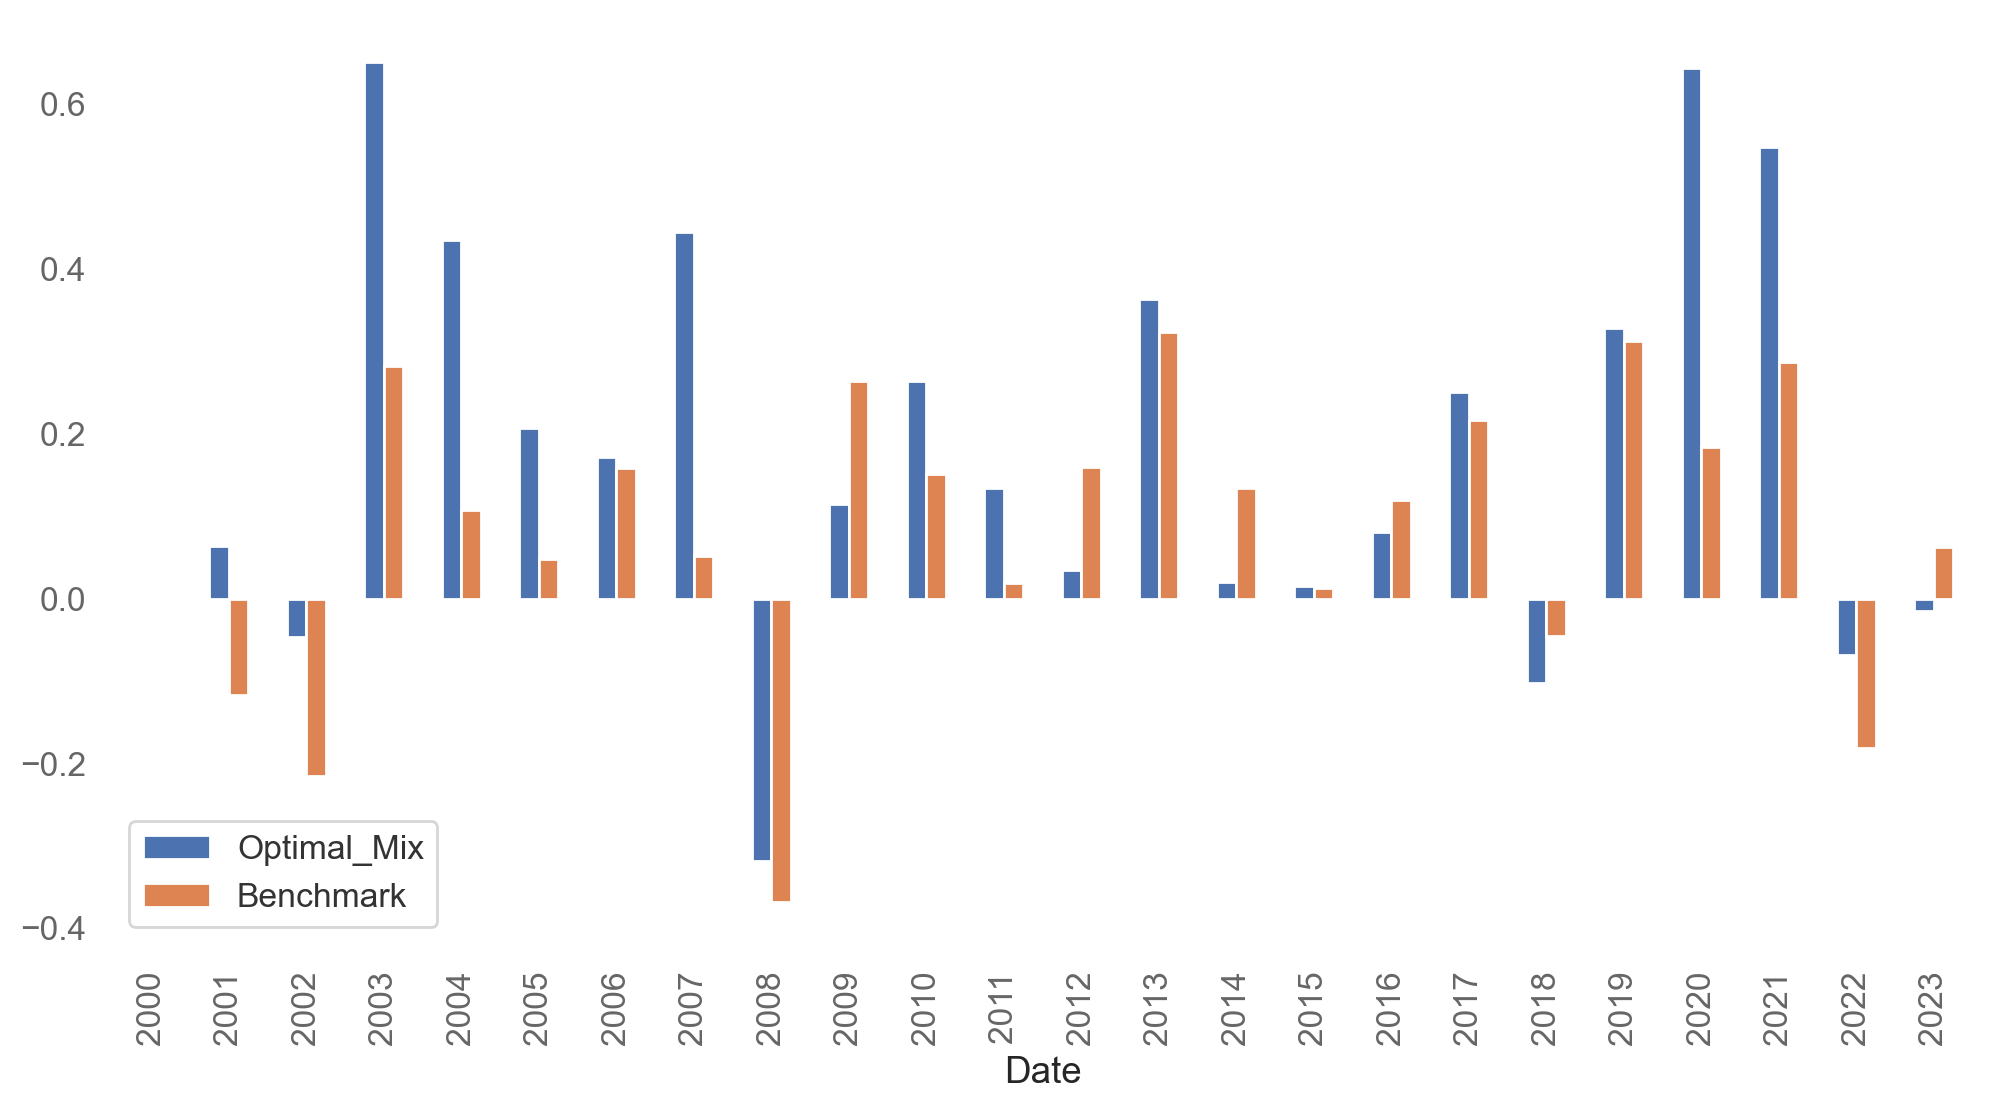

In [ ]:
anual_st = strategy.resample('Y').last().pct_change()
anual_bench = benchmark.resample('Y').last().pct_change()

df = pd.concat([anual_st, anual_bench], axis=1)
df.index = df.index.year
df.plot(kind='bar', figsize=(12,6))

# Mas Ratios

https://riskfolio-lib.readthedocs.io/en/latest/risk.html

* ’GMD’: Gini Mean Difference.
* ’FLPM’: First Lower Partial Moment (Omega Ratio).
* ’SLPM’: Second Lower Partial Moment (Sortino Ratio).
* ’TG’: Tail Gini.
* ’EVaR’: Entropic Value at Risk.
* ’WR’: Worst Realization (Minimax).
* ’RG’: Range of returns.
* ’CVRG’: CVaR range of returns.
* ’TGRG’: Tail Gini range of returns.
* ’MDD’: Maximum Drawdown of uncompounded cumulative returns (Calmar Ratio).
* ’ADD’: Average Drawdown of uncompounded cumulative returns.
* ’DaR’: Drawdown at Risk of uncompounded cumulative returns.
* ’CDaR’: Conditional Drawdown at Risk of uncompounded cumulative returns.
* ’EDaR’: Entropic Drawdown at Risk of uncompounded cumulative returns.
* ’UCI’: Ulcer Index of uncompounded cumulative returns.
* ’MDD_Rel’: Maximum Drawdown of compounded cumulative returns (Calmar Ratio).
* ’ADD_Rel’: Average Drawdown of compounded cumulative returns.
* ’CDaR_Rel’: Conditional Drawdown at Risk of compounded cumulative returns.
* ’EDaR_Rel’: Entropic Drawdown at Risk of compounded cumulative returns.
* ’UCI_Rel’: Ulcer Index of compounded cumulative returns.